In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import statsmodels.api as sm
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

df_trans = pd.read_csv("transaction_new.csv")
df_cust = pd.read_csv("customer.csv")
df_prod = pd.read_csv("product.csv")
df_click = pd.read_csv("click_stream_new.csv")
df_churn = pd.read_csv("df_customer_churn.csv")

In [ ]:
##### 데이터 전처리 #####
# 테이블 조인
df_temp = pd.merge(df_trans, df_cust, on='customer_id', how='left')
df_temp = pd.merge(df_temp, df_prod, left_on='product_id', right_on='id', how='left')
df_temp = df_temp.merge(df_click[['session_id', 'product_id', 'traffic_source']], on=['session_id', 'product_id'], how='left')

# 주문월 변수 생성
df_temp['created_at'] = pd.to_datetime(df_temp['created_at'])
df_temp['order_month'] = df_temp['created_at'].dt.to_period('M')
df_temp['order_month'] = df_temp['order_month'].astype(str)  # Period 객체를 문자열로 변환

# 주문주 변수 생성
df_temp['order_week'] = df_temp['created_at'].dt.to_period('W')
df_temp['order_week'] = df_temp['order_week'].astype(str)  # Period 객체를 문자열로 변환
df_temp['order_week'] = df_temp['order_week'].apply(lambda x: x.split('/')[0])

# 주문일 변수 생성
df_temp['order_date'] = df_temp['created_at'].dt.to_period('D')
df_temp['order_date'] = df_temp['order_date'].astype(str)  # Period 객체를 문자열로 변환

# 각 행(주문 상품별)별 개별 주문 금액 컬럼 total_price 생성 -> 각 행마다 개별 금액을 가지기 위함 (데이터 원자성)
df_temp['total_price'] = df_temp['item_price'] * df_temp['quantity']

# 나이 컬럼 생성
df_temp['birthdate'] = pd.to_datetime(df_temp['birthdate'])
df_temp['created_at'] = pd.to_datetime(df_temp['created_at']).dt.tz_localize(None)  # 시간대 정보 제거
df_temp['birthdate'] = pd.to_datetime(df_temp['birthdate']).dt.tz_localize(None)  # 시간대 정보 제거
df_temp['age'] = ((df_temp['created_at'] - df_temp['birthdate']).dt.days // 365).astype(int)

# 연령대 생성 (10대, 20대, ...)
bins = [0, 19, 29, 39, 49, 59, 69, 100]
labels = ['10s', '20s', '30s', '40s', '50s', '60s', '70+']
df_temp['age_group'] = pd.cut(df_temp['age'], bins=bins, labels=labels, right=False)

/Users/mcm01/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
/Users/mcm01/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
/Users/mcm01/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


# 문제 파악을 위한 시각화: 최근 매출액(판매액) 급감

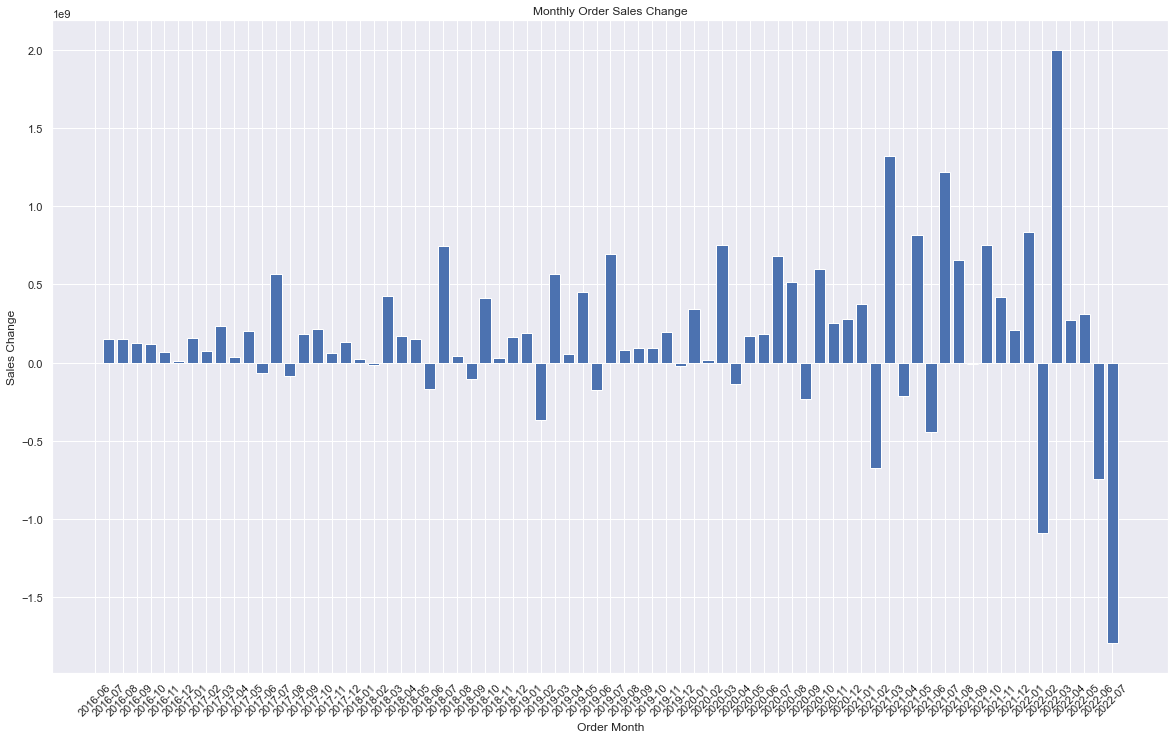

In [ ]:
df_vis = df_temp.copy()

df_vis = df_vis.groupby(['order_month','booking_id'])['total_price'].agg(['sum']).reset_index()
monthly_order_quantity = df_vis.groupby('order_month')['sum'].agg(['sum'])
monthly_order_quantity_diff = monthly_order_quantity.diff()

# 시각화
plt.figure(figsize=(20, 12))
x_values = range(len(monthly_order_quantity_diff.index))
plt.bar(x_values, monthly_order_quantity_diff.values.flatten())  # flatten 추가
plt.title('Monthly Order Sales Change')
plt.xlabel('Order Month')
plt.ylabel('Sales Change')
plt.xticks(x_values, monthly_order_quantity_diff.index, rotation=45)
plt.show()

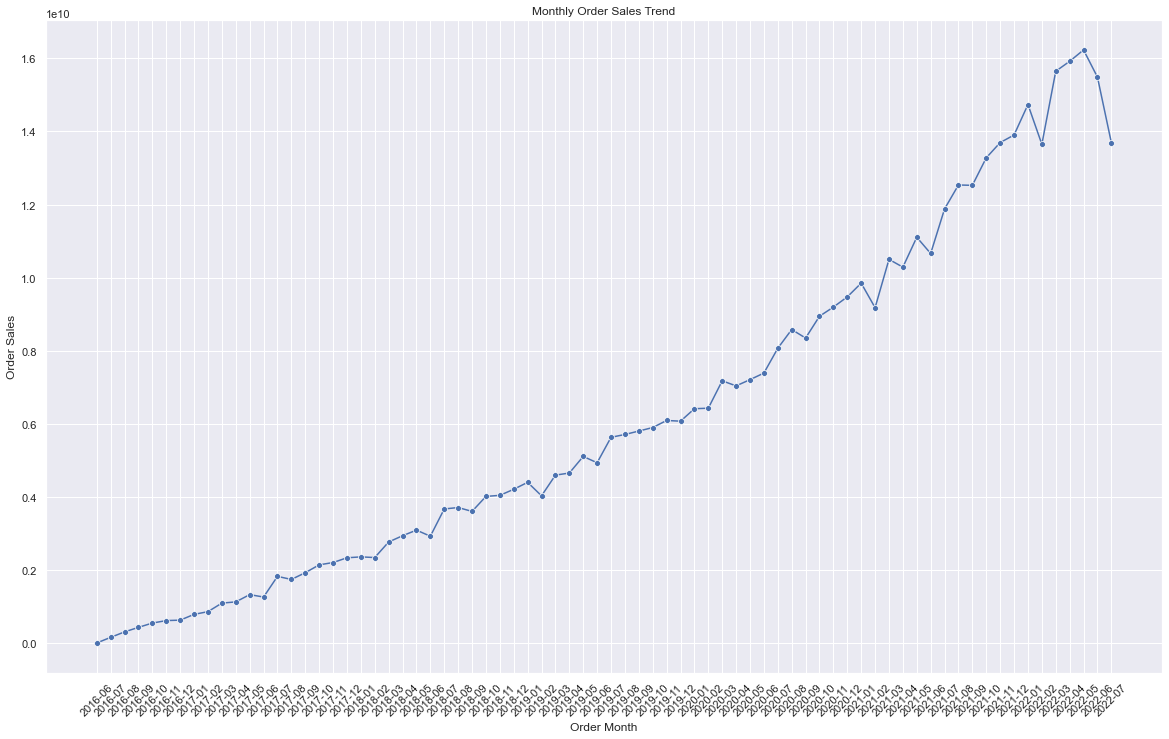

In [ ]:
df_vis = df_temp.copy()

# 월별 주문 수량 계산
monthly_order_sales = df_vis.groupby('order_month')['total_price'].sum()

# Seaborn 스타일 설정
sns.set()

# 시각화
plt.figure(figsize=(20, 12))
sns.lineplot(data=monthly_order_sales, marker='o')
plt.title('Monthly Order Sales Trend')
plt.xlabel('Order Month')
plt.ylabel('Order Sales')
plt.xticks(rotation=45)
plt.show()

#### 소결론: 최근 2022-06 ~ 2022-07 연속 2개월간 큰 폭으로 매출액이 감소함

In [ ]:
# 변화율 계산 함수
def calculate_change_rate(values):
    return (values - values.shift(1)) / values.shift(1) * 100

periods = [['2022-06', '2022-07'], ['2022-04', '2022-05']]

merged_df = pd.DataFrame()
results = pd.DataFrame()

for date in periods:
    subset = df_temp[df_temp['order_month'].isin(date)]
    grouped = subset.groupby('order_month')['total_price'].sum().reset_index()
    # periods 값을 이용하여 'group' 변수에 할당
    grouped.loc[:, 'group'] = f"{date[0]} ~ {date[1]}"
    results.append(grouped)
    merged_df = pd.concat([merged_df, grouped], axis=0, ignore_index=True)

change_rate_df = pd.DataFrame()

filtered_df = merged_df.groupby(['group'])['total_price'].agg(['sum']).reset_index()
filtered_df['change_rate'] = calculate_change_rate(filtered_df['sum'])
change_rate_df = pd.concat([change_rate_df, filtered_df], axis=0, ignore_index=True)

standard = change_rate_df.loc[change_rate_df['change_rate'] < 0]['change_rate'].quantile(0.75)
print(standard)
change_rate_df

-9.236488919611803


<ipython-input-116-17ebd6df3671>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results.append(grouped)
<ipython-input-116-17ebd6df3671>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results.append(grouped)


,group,sum,change_rate
0,2022-04 ~ 2022-05,32151072251,NaN
1,2022-06 ~ 2022-07,29181442025,-9.236489


In [ ]:
from scipy.stats import mannwhitneyu

def nonparametric_test(df, x_var, y_var, hue_var=None):

    grp_list = df[x_var].unique().tolist()
    grp_a = df.loc[df[x_var] == grp_list[0]][y_var]
    grp_b = df.loc[df[x_var] == grp_list[1]][y_var]

    # 비모수적 검정 (Mann-Whitney U 검정)
    statistic, p_value = mannwhitneyu(grp_a, grp_b, alternative='two-sided')

    print("Mann-Whitney U 검정 결과:")
    print(f"통계량 (U 값): {statistic}")
    print(f"p-value: {p_value}")

    # 시각화
    plt.figure(figsize=(10, 8))
    sns.boxplot(data=df, x=x_var, y=y_var, hue=hue_var, showfliers=False)
#     plt.xticks([0, 1], [grpA['order_month_group'][0], grpB['order_month_group'][0]])
#     plt.xlabel(f'{x_var}')
#     plt.ylabel(f'{y_var}')
#     plt.title(f'Comparison of {x_var}')
    plt.show()

In [ ]:
# order_month가 '2022-04' 이상인 관찰값 필터링
df_filtered = df_temp[df_temp['order_month'] >= '2022-04'].copy()

# 새로운 변수를 만들어 group 구분
df_filtered['order_month_group'] = np.where(df_filtered['order_month'].isin(['2022-04', '2022-05']), '2022-04 ~ 2022-05', np.where(df_filtered['order_month'].isin(['2022-06', '2022-07']), '2022-06 ~ 2022-07', 'Other'))

# 그룹화 및 집계
df_filtered = df_filtered.groupby(['order_date', 'order_month_group']).agg({
    'total_price': 'sum'
}).reset_index()

# # 그룹별 추출
# df_grouped_0405 = dt_filtered[dt_filtered['order_month_group'] == '2022-04 ~ 2022-05'].reset_index(drop=True)
# df_grouped_0607 = dt_filtered[dt_filtered['order_month_group'] == '2022-06 ~ 2022-07'].reset_index(drop=True)

Mann-Whitney U 검정 결과:
통계량 (U 값): 2572.0
p-value: 0.0002719603232800299


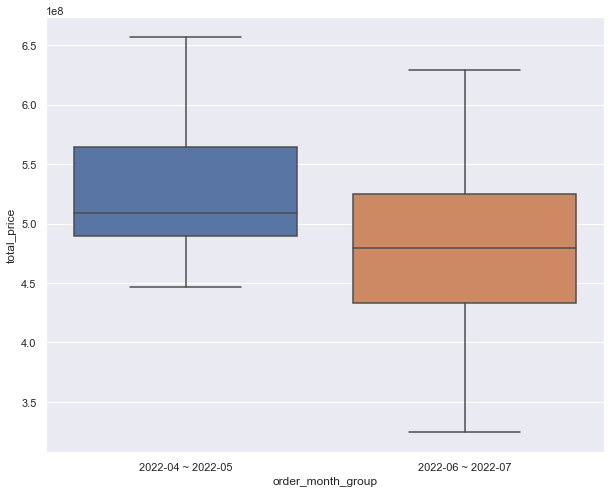

In [ ]:
nonparametric_test(df_filtered, 'order_month_group', 'total_price')

#### 소결론: 두 기간동안의 매출액은 통계적으로 유의한 차이가 있음

# 주문당 단가

In [ ]:
# order_month가 '2022-04' 이상인 관찰값 필터링
df_filtered = df_temp[df_temp['order_month'] >= '2022-04'].copy()

# 새로운 변수를 만들어 group 구분
df_filtered['order_month_group'] = np.where(df_filtered['order_month'].isin(['2022-04', '2022-05']), '2022-04 ~ 2022-05', np.where(df_filtered['order_month'].isin(['2022-06', '2022-07']), '2022-06 ~ 2022-07', 'Other'))

# 그룹화 및 집계
df_filtered = df_filtered.groupby(['order_date', 'order_month_group', 'booking_id']).agg({
    'total_price': 'sum'
}).reset_index()

df_filtered.rename(columns={'total_price': 'pricePerBooking'}, inplace=True)


# # 그룹별 추출
# df_grouped_0405 = dt_filtered[dt_filtered['order_month_group'] == '2022-04 ~ 2022-05'].reset_index(drop=True)
# df_grouped_0607 = dt_filtered[dt_filtered['order_month_group'] == '2022-06 ~ 2022-07'].reset_index(drop=True)

Mann-Whitney U 검정 결과:
통계량 (U 값): 1596088925.5
p-value: 0.7334295836174162


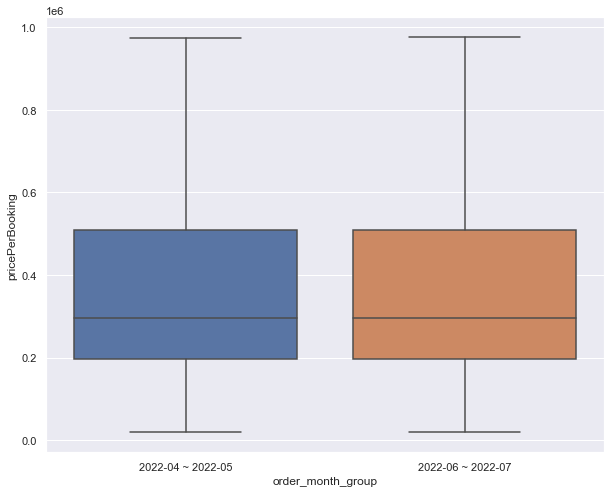

In [ ]:
nonparametric_test(df_filtered, 'order_month_group', 'pricePerBooking')

# 주문당 구매품목수

In [ ]:
# order_month가 '2022-04' 이상인 관찰값 필터링
df_filtered = df_temp[df_temp['order_month'] >= '2022-04'].copy()

# 새로운 변수를 만들어 group 구분
df_filtered['order_month_group'] = np.where(df_filtered['order_month'].isin(['2022-04', '2022-05']), '2022-04 ~ 2022-05', np.where(df_filtered['order_month'].isin(['2022-06', '2022-07']), '2022-06 ~ 2022-07', 'Other'))

# 그룹화 및 집계
df_filtered = df_filtered.groupby(['order_date', 'order_month_group', 'booking_id']).agg({
    'quantity': 'sum'
}).reset_index()

# df_filtered.rename(columns={'total_price': 'pricePerBooking'}, inplace=True)


# # 그룹별 추출
# df_grouped_0405 = dt_filtered[dt_filtered['order_month_group'] == '2022-04 ~ 2022-05'].reset_index(drop=True)
# df_grouped_0607 = dt_filtered[dt_filtered['order_month_group'] == '2022-06 ~ 2022-07'].reset_index(drop=True)

Mann-Whitney U 검정 결과:
통계량 (U 값): 1596326172.5
p-value: 0.6407599330242484


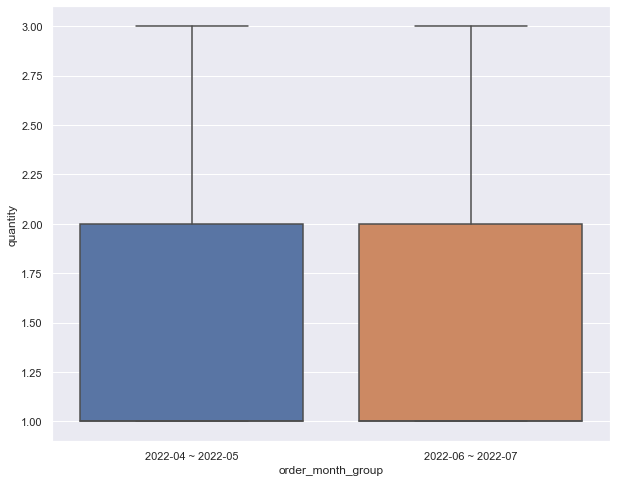

In [ ]:
nonparametric_test(df_filtered, 'order_month_group', 'quantity')

# 고객당 구매빈도

In [ ]:
# order_month가 '2022-04' 이상인 관찰값 필터링
df_filtered = df_temp[df_temp['order_month'] >= '2022-04'].copy()

# 새로운 변수를 만들어 group 구분
df_filtered['order_month_group'] = np.where(df_filtered['order_month'].isin(['2022-04', '2022-05']), '2022-04 ~ 2022-05', np.where(df_filtered['order_month'].isin(['2022-06', '2022-07']), '2022-06 ~ 2022-07', 'Other'))

# 그룹화 및 집계
df_filtered = df_filtered.groupby(['order_date', 'order_month_group', 'customer_id']).agg({
    'booking_id': 'count'
}).reset_index()

# df_filtered.rename(columns={'total_price': 'pricePerBooking'}, inplace=True)


# # 그룹별 추출
# df_grouped_0405 = dt_filtered[dt_filtered['order_month_group'] == '2022-04 ~ 2022-05'].reset_index(drop=True)
# df_grouped_0607 = dt_filtered[dt_filtered['order_month_group'] == '2022-06 ~ 2022-07'].reset_index(drop=True)

Mann-Whitney U 검정 결과:
통계량 (U 값): 1532128535.0
p-value: 0.27828892237628744


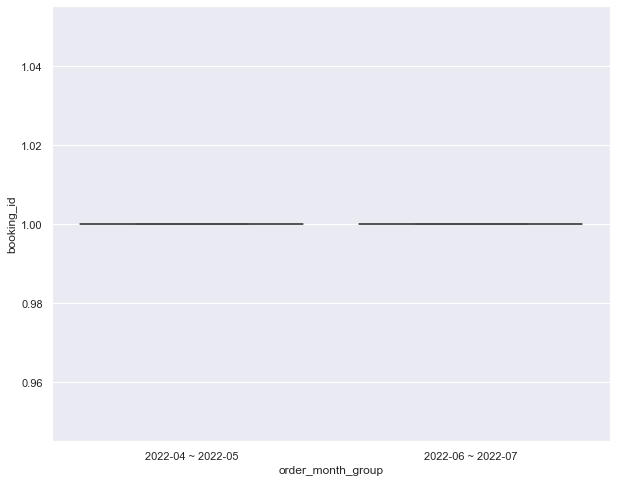

In [ ]:
nonparametric_test(df_filtered, 'order_month_group', 'booking_id')

# 고객수

In [ ]:
# order_month가 '2022-04' 이상인 관찰값 필터링
df_filtered = df_temp[df_temp['order_month'] >= '2022-04'].copy()

# 새로운 변수를 만들어 group 구분
df_filtered['order_month_group'] = np.where(df_filtered['order_month'].isin(['2022-04', '2022-05']), '2022-04 ~ 2022-05', np.where(df_filtered['order_month'].isin(['2022-06', '2022-07']), '2022-06 ~ 2022-07', 'Other'))

# 그룹화 및 집계
df_filtered = df_filtered.groupby(['order_date', 'order_month_group']).agg({
    'customer_id': 'count'
}).reset_index()

# df_filtered.rename(columns={'total_price': 'pricePerBooking'}, inplace=True)


# # 그룹별 추출
# df_grouped_0405 = dt_filtered[dt_filtered['order_month_group'] == '2022-04 ~ 2022-05'].reset_index(drop=True)
# df_grouped_0607 = dt_filtered[dt_filtered['order_month_group'] == '2022-06 ~ 2022-07'].reset_index(drop=True)

Mann-Whitney U 검정 결과:
통계량 (U 값): 2654.5
p-value: 4.8411718904379265e-05


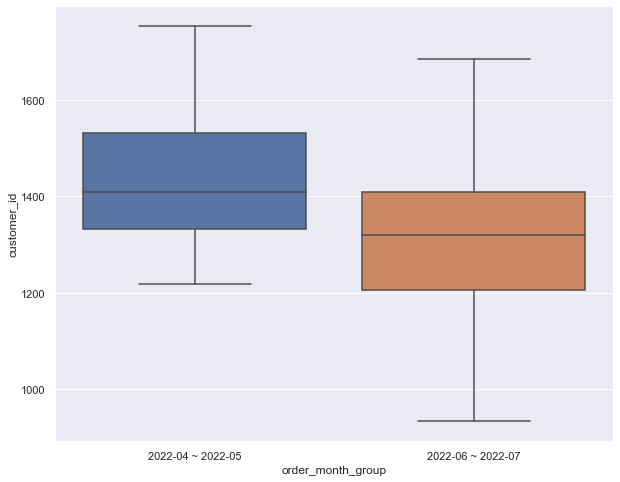

In [ ]:
nonparametric_test(df_filtered, 'order_month_group', 'customer_id')

# 범주형 변수별 매출 변화 추이

In [ ]:
# 비교기간 설정
periods = [['2022-06', '2022-07'], ['2022-04', '2022-05']]

# 변화율 계산 함수
def calculate_change_rate(values):
    return (values - values.shift(1)) / values.shift(1) * 100

# 플롯 및 변화율 테이블 생성 함수
def plot_comparison(selected_var, width=12, height=6):
    results = []
    merged_df = pd.DataFrame()

    for date in periods:
        subset = df_temp[df_temp['order_month'].isin(date)]
        grouped = subset.groupby([selected_var])['total_price'].sum().reset_index()
        # periods 값을 이용하여 'group' 변수에 할당
        grouped.loc[:, 'group'] = f"{date[0]} ~ {date[1]}"
        results.append(grouped)
        merged_df = pd.concat([merged_df, grouped], axis=0, ignore_index=True)

    # 시각화
    plt.figure(figsize=(width, height))
    sns.set_palette("pastel")
    for i, date in enumerate(periods):
        plt.plot(results[i][selected_var], results[i]['total_price'], label=f'{date}')

    plt.title(f'Sales by {selected_var} and Period')
    plt.xlabel(f'{selected_var}')
    plt.ylabel('Total Amount')
    plt.legend()
    plt.show()

    change_rate_df = pd.DataFrame()

    group_categories = df_temp[selected_var].unique().tolist()

    for group in group_categories:
        filtered_df = merged_df.groupby(['group', selected_var])['total_price'].agg(['sum']).reset_index()
        filtered_df = filtered_df[filtered_df[selected_var] == group]
        filtered_df['change_rate'] = calculate_change_rate(filtered_df['sum'])
        change_rate_df = pd.concat([change_rate_df, filtered_df], axis=0, ignore_index=True)

#     standard = change_rate_df.loc[change_rate_df['change_rate'] < 0]['change_rate'].quantile(0.75)
#     print(standard)
    change_rate_df_by_standard = change_rate_df.loc[change_rate_df['change_rate'] < standard]

    display(change_rate_df_by_standard)

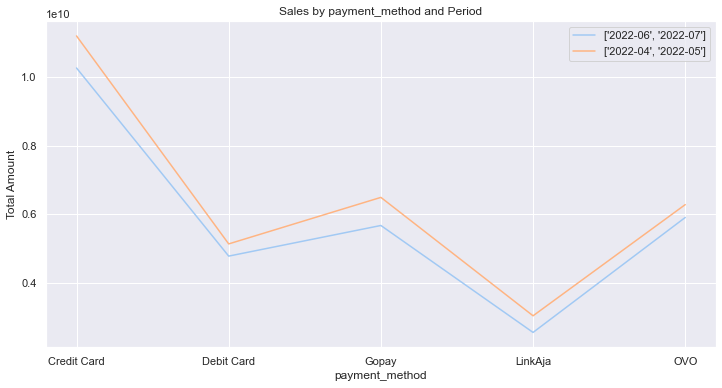

,group,payment_method,sum,change_rate
7,2022-06 ~ 2022-07,LinkAja,2555456699,-15.954955
9,2022-06 ~ 2022-07,Gopay,5673236490,-12.619180


In [ ]:
plot_comparison('payment_method')

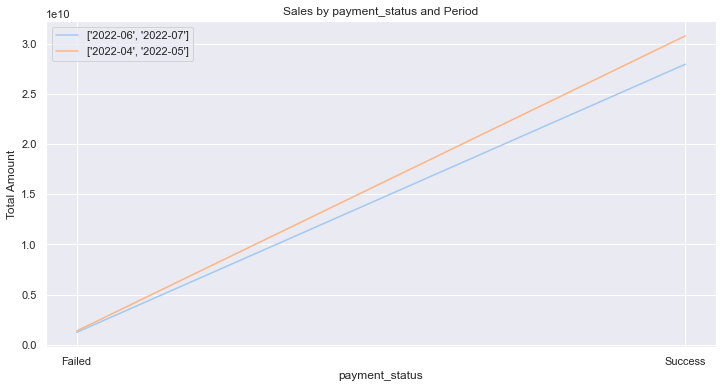

,group,payment_status,sum,change_rate
3,2022-06 ~ 2022-07,Failed,1223627981,-10.33689


In [ ]:
plot_comparison('payment_status')

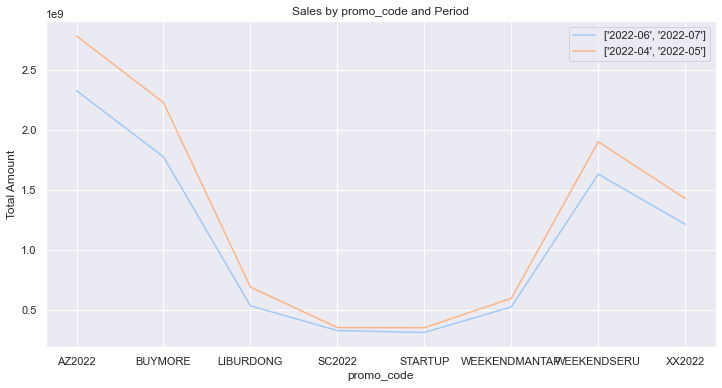

,group,promo_code,sum,change_rate
1,2022-06 ~ 2022-07,WEEKENDSERU,1632167298,-14.176979
3,2022-06 ~ 2022-07,WEEKENDMANTAP,524900836,-11.973498
5,2022-06 ~ 2022-07,AZ2022,2328246828,-16.373922
7,2022-06 ~ 2022-07,LIBURDONG,534105290,-22.633198
9,2022-06 ~ 2022-07,BUYMORE,1776013732,-20.322552
11,2022-06 ~ 2022-07,XX2022,1213198098,-15.076976
13,2022-06 ~ 2022-07,STARTUP,311709774,-11.261441


In [ ]:
plot_comparison('promo_code')

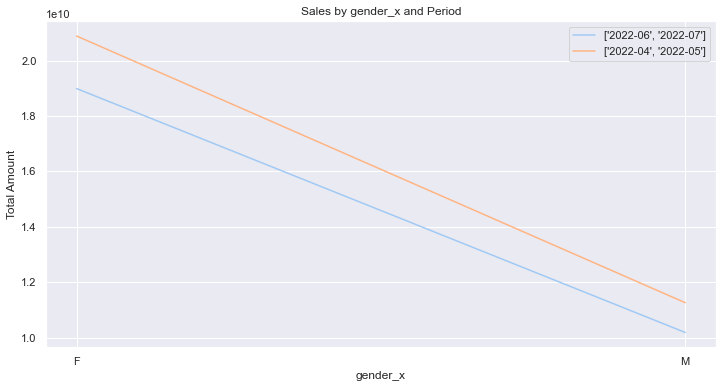

,group,gender_x,sum,change_rate
3,2022-06 ~ 2022-07,M,10190796696,-9.531929


In [ ]:
plot_comparison('gender_x')

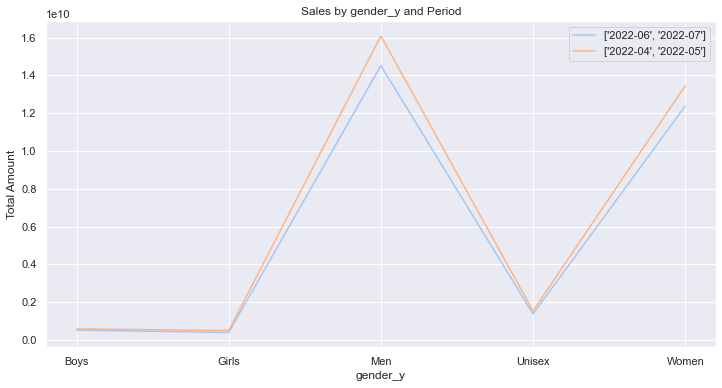

,group,gender_y,sum,change_rate
1,2022-06 ~ 2022-07,Men,14511839220,-9.761215
5,2022-06 ~ 2022-07,Unisex,1375852781,-10.559516
7,2022-06 ~ 2022-07,Girls,396919211,-20.177470
9,2022-06 ~ 2022-07,Boys,520787134,-11.632679


In [ ]:
plot_comparison('gender_y')

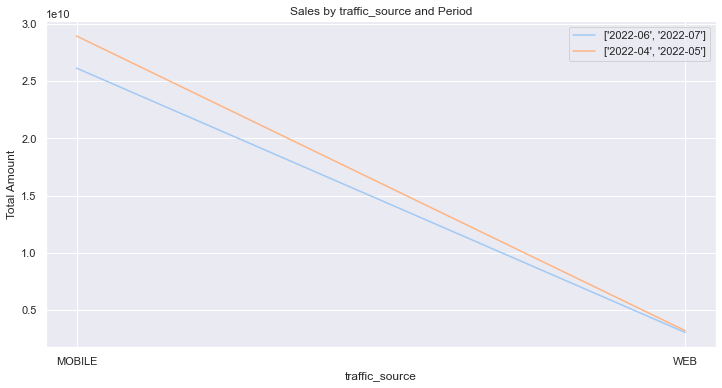

,group,traffic_source,sum,change_rate
3,2022-06 ~ 2022-07,MOBILE,26157129279,-9.712214


In [ ]:
plot_comparison('traffic_source')

# 체류시간별 매출 변화 추이 확인

In [ ]:
##### Session ID로 그룹화 #####
df_temp_session = df_temp.groupby('session_id').agg(
    payment_method=pd.NamedAgg(column='payment_method', aggfunc='first'),
    payment_status=pd.NamedAgg(column='payment_status', aggfunc='first'),
    promo_code=pd.NamedAgg(column='promo_code', aggfunc='first'),
    product_count=pd.NamedAgg(column='product_id', aggfunc='nunique'),  # 중복되지 않은 product_id 카운트 추가,
    gender_x=pd.NamedAgg(column='gender_x', aggfunc='first'),
    gender_y=pd.NamedAgg(column='gender_y', aggfunc='first'),
    age=pd.NamedAgg(column='age', aggfunc='first'),
    age_group=pd.NamedAgg(column='age_group', aggfunc='first'),
    device_type=pd.NamedAgg(column='device_type', aggfunc='first'),
    total_quantity=pd.NamedAgg(column='quantity', aggfunc='sum'),
    total_price=pd.NamedAgg(column='total_price', aggfunc='sum')
).reset_index()

In [ ]:
# df_click 데이터 전처리
df_click['event_time'] = pd.to_datetime(df_click['event_time'])
df_click_session = df_click.groupby('session_id').agg(
    event_time_start=pd.NamedAgg(column='event_time', aggfunc='min'),
    stay_time=pd.NamedAgg(column='event_time', aggfunc=lambda x: (x.max() - x.min())),
    scroll_count=pd.NamedAgg(column='event_name', aggfunc=lambda x: (x == 'SCROLL').sum())  # SCROLL 횟수 카운트 추가

).reset_index()

df_click_session['event_month'] = df_click_session['event_time_start'].dt.strftime('%Y-%m')
df_click_session['event_date'] = df_click_session['event_time_start'].dt.strftime('%Y-%m-%d')
df_click_session['stay_time_minutes'] = df_click_session['stay_time'].dt.total_seconds() / 60
df_click_session['stay_time_day'] = df_click_session['stay_time'] / pd.Timedelta(days=1)

In [ ]:
# 데이터 통합
df_unified = df_click_session.merge(df_temp_session, on=['session_id'], how='left')
df_unified['stay_time_minutes'] = df_unified['stay_time'].dt.total_seconds() / 60
df_unified['stay_time_day'] = df_unified['stay_time'] / pd.Timedelta(days=1)

In [ ]:
def outlier_remover(df, var):
    # 아웃라이어 제거
    # IQR 계산
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1

    # IQR을 이용한 아웃라이어 범위 계산
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # 아웃라이어 제거
    df_filtered = df[(df[var] >= lower_bound) & (df[var] <= upper_bound)]
    return df_filtered

In [ ]:
df_filtered = outlier_remover(df_unified, 'stay_time')
# df_filtered = outlier_remover(df_filtered, 'scroll_count')
# df_filtered = outlier_remover(df_filtered, 'product_count')
# df_filtered = outlier_remover(df_filtered, 'total_price')

df_unified_date = df_filtered.groupby(['event_month','event_date']).agg(
    stay_time=pd.NamedAgg(column='stay_time', aggfunc='mean'),
    scroll_count=pd.NamedAgg(column='scroll_count', aggfunc='mean'),
    product_count=pd.NamedAgg(column='product_count', aggfunc='mean'),
    total_quantity=pd.NamedAgg(column='total_quantity', aggfunc='sum'),
    total_price=pd.NamedAgg(column='total_price', aggfunc='sum')
).reset_index()

df_unified_date['stay_time_minutes'] = df_unified_date['stay_time'].dt.total_seconds() / 60
df_unified_date['stay_time_day'] = df_unified_date['stay_time'] / pd.Timedelta(days=1)

In [ ]:
# order_month가 '2022-04' 이상인 관찰값 필터링
df_filtered = df_unified_date[df_unified_date['event_month'] >= '2022-04'].copy()

# 새로운 변수를 만들어 group 구분
df_filtered['event_month_group'] = np.where(df_filtered['event_month'].isin(['2022-04', '2022-05']), '2022-04 ~ 2022-05', np.where(df_filtered['event_month'].isin(['2022-06', '2022-07']), '2022-06 ~ 2022-07', 'Other'))

# 그룹화 및 집계
df_filtered = df_filtered.groupby(['event_date', 'event_month_group']).agg({
    'stay_time_minutes': 'mean',
    'scroll_count':'mean',
    'total_price':'sum'
}).reset_index()

# df_filtered.rename(columns={'total_price': 'pricePerBooking'}, inplace=True)


# # 그룹별 추출
# df_grouped_0405 = dt_filtered[dt_filtered['order_month_group'] == '2022-04 ~ 2022-05'].reset_index(drop=True)
# df_grouped_0607 = dt_filtered[dt_filtered['order_month_group'] == '2022-06 ~ 2022-07'].reset_index(drop=True)

Mann-Whitney U 검정 결과:
통계량 (U 값): 3608.0
p-value: 3.7051025449859537e-19


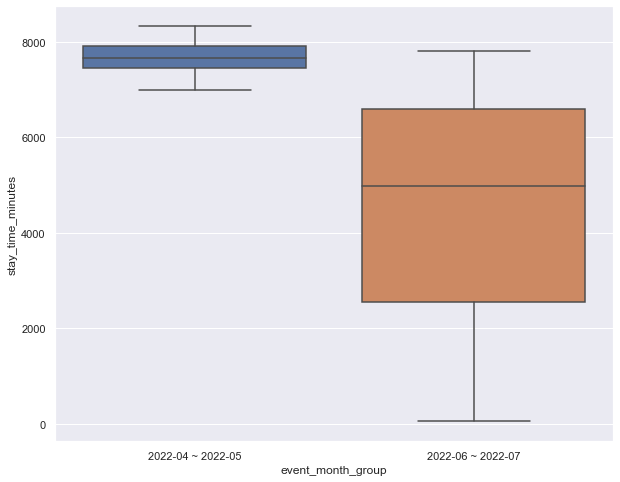

In [ ]:
nonparametric_test(df_filtered, 'event_month_group', 'stay_time_minutes')

#### 소결론: 2022-06 ~ 2022-07에서 평균체류시간이 감소했으며, 이는 2022-04 ~ 2022-05의 체류시간과 통계적으로 유의한 차이가 있음

Mann-Whitney U 검정 결과:
통계량 (U 값): 392.0
p-value: 5.612358403481359e-14


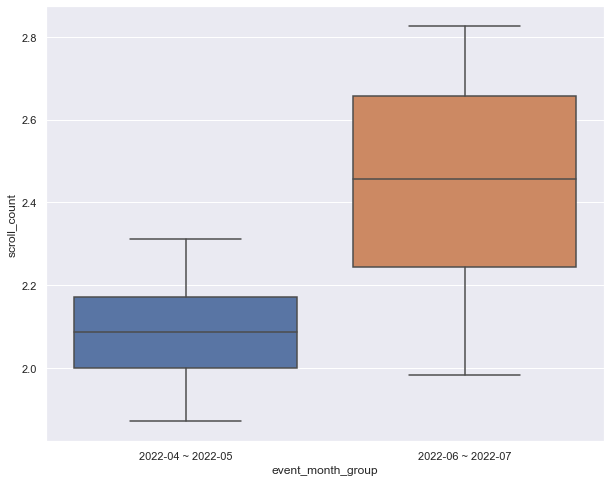

In [ ]:
nonparametric_test(df_filtered, 'event_month_group', 'scroll_count')

#### 소결론: 평균 스크롤 카운트가 6-7월에는 통계적으로 유의하게 4-5월에 비해 많이 늘었다.

## 변수별 상관관계

### 체류시간과 매출액의 상관관계

In [ ]:
def scatter_plot(x_var, y_var):

    # scatter plot 그리기
    plt.figure(figsize=(10, 6))
    plt.scatter(df_test[x_var], df_test[y_var], alpha=0.5)
    plt.title(f'Scatter Plot of {x_var} vs {y_var}')
    plt.xlabel(f'{x_var}')
    plt.ylabel(f'{y_var}')
    plt.grid(True)

    # 회귀선 추가
    coefficients = np.polyfit(df_test[x_var], df_test[y_var], 1)  # 1차원 선형 회귀
    polynomial = np.poly1d(coefficients)
    x_range = np.linspace(min(df_test[x_var]), max(df_test[x_var]), 100)
    plt.plot(x_range, polynomial(x_range), color='red', label='Regression Line')

    plt.legend()
    plt.show()

    # scatter plot 그리기
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_test, x=x_var, y=y_var, hue='event_month', alpha=0.5)
    plt.title(f'Scatter Plot of {x_var} vs {y_var}')
    plt.xlabel(f'{x_var}')
    plt.ylabel(f'{y_var}')
    plt.grid(True)
    plt.legend(title='Event Month')

    # 회귀선 추가
    for month in df_test['event_month'].unique():
        df_month = df_test[df_test['event_month'] == month]
        coefficients = np.polyfit(df_month[x_var], df_month[y_var], 1)  # 1차원 선형 회귀
        polynomial = np.poly1d(coefficients)
        x_range = np.linspace(min(df_month[x_var]), max(df_month[x_var]), 100)
        plt.plot(x_range, polynomial(x_range), label=f'Regression Line - {month}')

    plt.legend()
    plt.show()

## 4-5월

In [ ]:
# df_test = df_unified_date.loc[df_unified_date['event_month'].isin(["2022-04", "2022-05"])]
#                               & (df_unified_date['event_month'] <= "2022-07")]

# df_test = df_unified_date.loc[(df_unified_date['event_month'].isin(["2022-04","2022-05","2022-06", "2022-07"]))]


df_test = df_unified_date.loc[(df_unified_date['event_month'] >= "2021-07")]



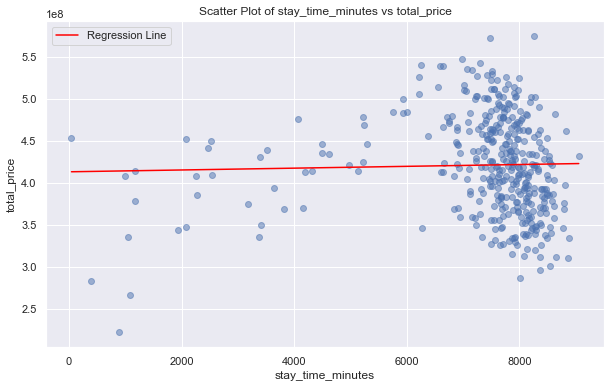

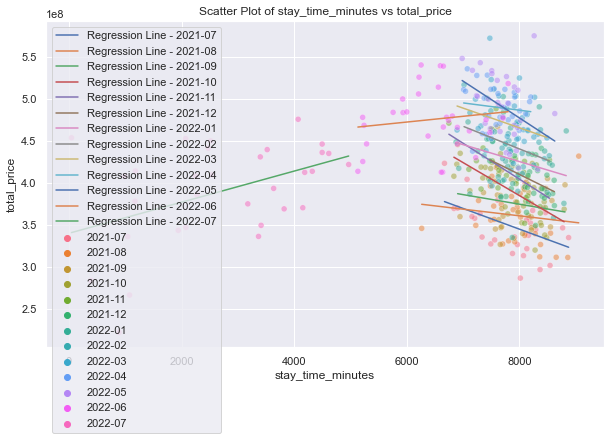

In [ ]:
scatter_plot('stay_time_minutes', 'total_price')

### 평균 스크롤 빈도수와 체류시간과의 상관관계

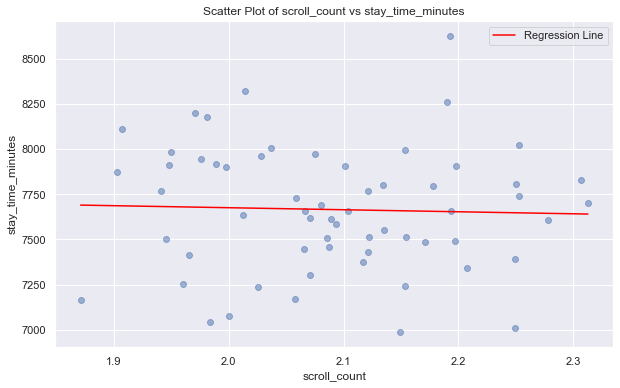

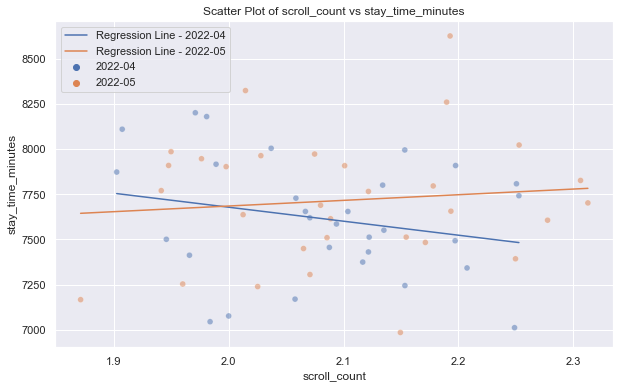

In [ ]:
scatter_plot('scroll_count', 'stay_time_minutes')

#### 소결론: 6-7월에 한해서 평균 스크롤 빈도수가 많을수록 체류시간이 짧았다

### 6-7월

In [ ]:
df_test = df_unified_date.loc[df_unified_date['event_month'].isin(["2022-06", "2022-07"])]

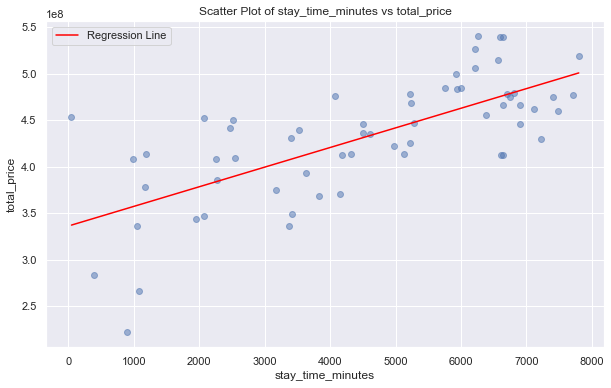

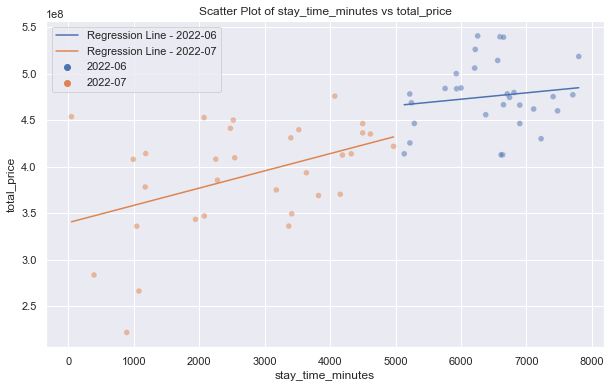

In [ ]:
scatter_plot('stay_time_minutes', 'total_price')

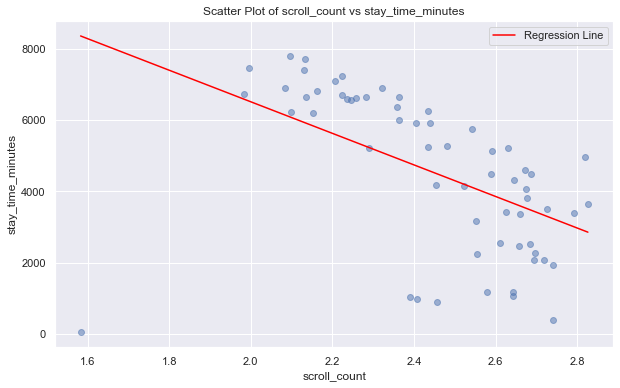

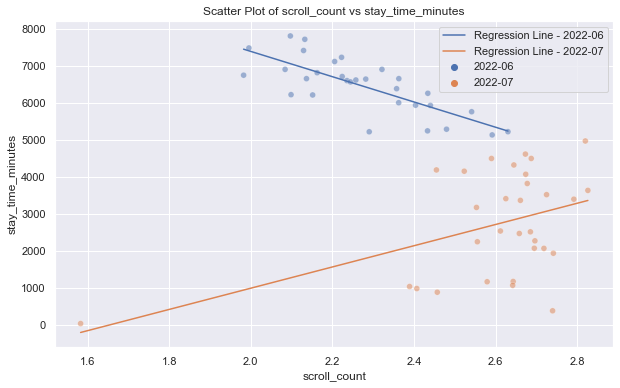

In [ ]:
scatter_plot('scroll_count', 'stay_time_minutes')

## 체류시간과 매출액 회귀분석

In [ ]:
import statsmodels.api as sm

# df_test = df_unified_date.loc[df_unified_date['event_month'] >= "2022-01"]

# 회귀 모델 생성 및 학습
X = df_test[['stay_time_minutes']]
X = sm.add_constant(X)
y = df_test['total_quantity']
model = sm.OLS(y, X).fit()

# 회귀 모델 결과 출력
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         total_quantity   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     59.51
Date:                Tue, 05 Sep 2023   Prob (F-statistic):           1.67e-10
Time:                        00:12:56   Log-Likelihood:                -403.97
No. Observations:                  61   AIC:                             811.9
Df Residuals:                      59   BIC:                             816.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1340.0717     55.21

#### 소결론: 체류시간과 매출액은 강한 상관관계가 있으며 체류시간이 많을수록 매출액도 증가하는 경향이 있음

In [ ]:
df_test = df_unified_date.loc[df_unified_date['event_date'] >= "2022-06-01"]


def comparison_trends(x_var1, y_var1, y_var2):
    # 그래프 생성
    fig, ax1 = plt.subplots(figsize=(60, 6))

    # stay_time_minutes 그래프 (왼쪽 y축)
    ax1.plot(df_test[x_var1], df_test[y_var1], marker='o', color='tab:blue', label=f'{y_var1}')
    ax1.set_xlabel('Event Date')
    ax1.set_ylabel(f'{y_var1}', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # total_price 그래프 (오른쪽 y축)
    ax2 = ax1.twinx()
    ax2.plot(df_test[x_var1], df_test[y_var2], marker='s', color='tab:orange', label=f'{y_var2}')
    ax2.set_ylabel(f'{y_var2}', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    # 그래프 제목과 레이블
    plt.title(f'{y_var1} and {y_var2} Change by {x_var1}')
    fig.tight_layout()
    plt.grid(True)
    plt.show()

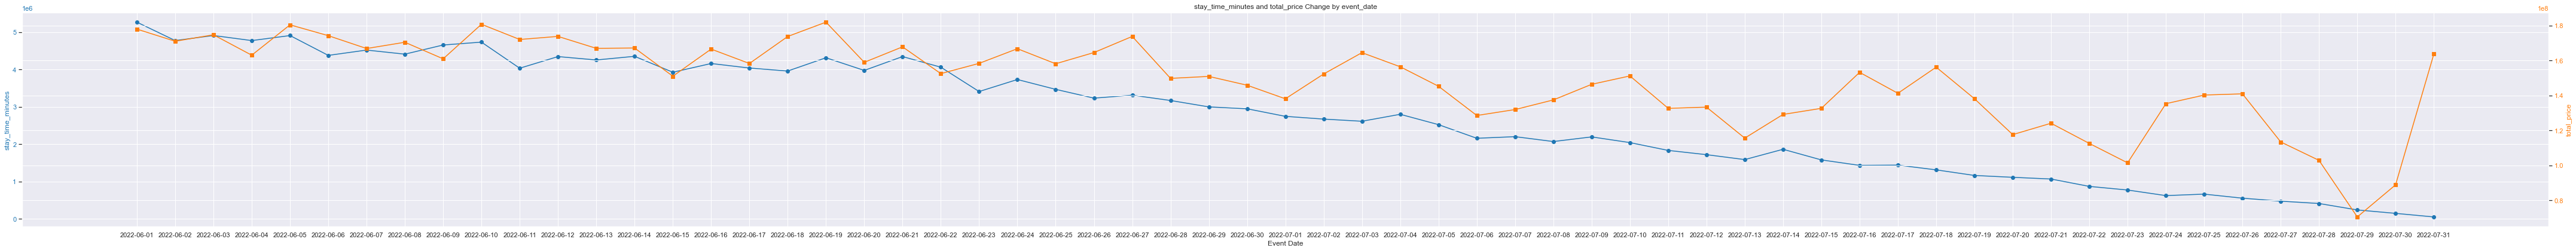

In [ ]:
# event_date와 stay_time_minutes, total_price 추출
comparison_trends('event_date', 'stay_time_minutes', 'total_price')

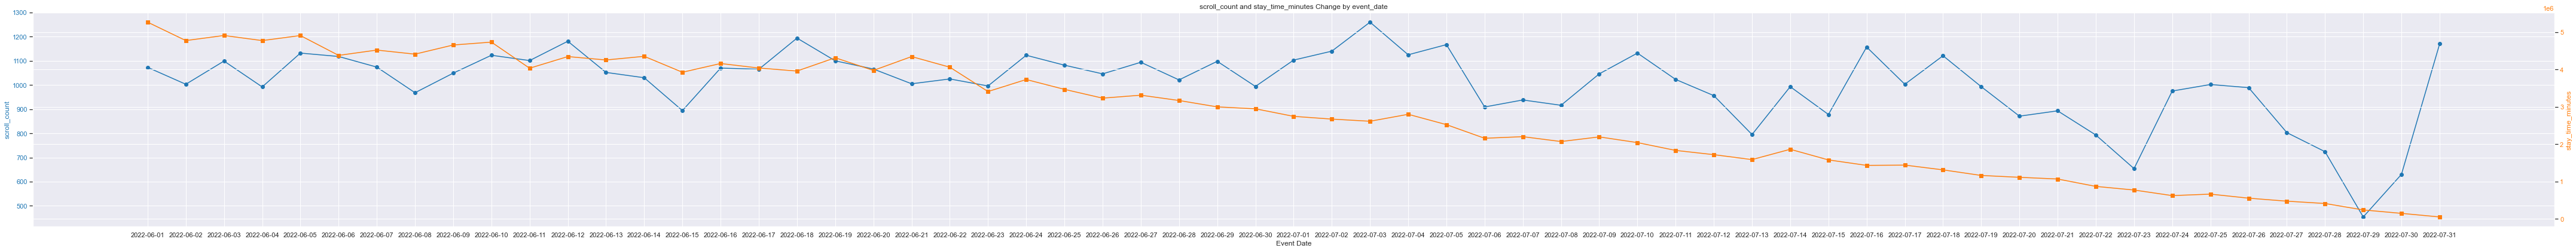

In [ ]:
# event_date와 stay_time_minutes, total_price 추출
comparison_trends('event_date', 'scroll_count', 'stay_time_minutes')

## 이슈트리 활용

In [ ]:
# # order_month가 '2022-04' 이상인 관찰값 필터링
df_temp2 = df_temp[df_temp['order_month'] >= '2016-07'].copy()

# # 새로운 변수를 만들어 group 구분
# df_filtered['order_month_group'] = np.where(df_filtered['order_month'].isin(['2022-04', '2022-05']), '2022-04 ~ 2022-05', np.where(df_filtered['order_month'].isin(['2022-06', '2022-07']), '2022-06 ~ 2022-07', 'Other'))

# df_spc = df_temp.groupby(['order_month', 'customer_id', 'booking_id', 'product_id']).agg(
#     total_price=pd.NamedAgg(column='total_price', aggfunc='sum')
# ).reset_index()

df_spc = df_temp2.groupby(['order_month', 'customer_id']).agg(
#     num_cust=pd.NamedAgg(column='customer_id', aggfunc='nunique'),
    num_book=pd.NamedAgg(column='booking_id', aggfunc='nunique'),
    num_prod=pd.NamedAgg(column='product_id', aggfunc='nunique'),
    total_price=pd.NamedAgg(column='total_price', aggfunc='sum')
).reset_index()

df_spc = df_spc.groupby(['order_month']).agg(
    num_cust=pd.NamedAgg(column='customer_id', aggfunc='nunique'),
    num_book=pd.NamedAgg(column='num_book', aggfunc='sum'),
    num_prod=pd.NamedAgg(column='num_prod', aggfunc='sum'),
    total_price=pd.NamedAgg(column='total_price', aggfunc='sum')
).reset_index()

# 매출액 = 주문건당 단가 x 주문 수
# (구매품목당 단가 x 주문건당 구매품목수) x (고객당 구매빈도 x 고객 수)

# df_spc['sales_per_cust'] = df_spc['total_price'] / df_spc['num_cust'] # num_cust = 고객 수
# df_spc['sales_per_cust'] = df_spc['sales_per_cust'].astype('int64')

# df_spc['sales_per_book'] = df_spc['total_price'] / df_spc['num_book']
# df_spc['sales_per_book'] = df_spc['sales_per_book'].astype('int64')

# 고객당 구매빈도: book_per_cust
df_spc['book_per_cust'] = df_spc['num_book'] / df_spc['num_cust']
df_spc['book_per_cust'] = round(df_spc['book_per_cust'].astype('float'), 2)

# df_spc['prod_per_cust'] = df_spc['num_prod'] / df_spc['num_cust']
# df_spc['prod_per_cust'] = round(df_spc['prod_per_cust'].astype('float'), 2)

# 구매품목당 단가: sales_per_prod
df_spc['sales_per_prod'] = df_spc['total_price'] / df_spc['num_prod']
df_spc['sales_per_prod'] = df_spc['sales_per_prod'].astype('int64')

# df_spc['price_per_prod'] = df_spc['sales_per_cust'] / df_spc['prod_per_cust']
# df_spc['price_per_prod'] = df_spc['price_per_prod'].astype('int64')

# df_spc['bookFreq_per_cust'] = df_spc['num_book'] / df_spc['num_cust']
# df_spc['bookFreq_per_cust'] = round(df_spc['bookFreq_per_cust'].astype('float'), 2)

# 주문건당 구매품목수: prod_per_book
df_spc['prod_per_book'] = df_spc['num_prod'] / df_spc['num_book']
df_spc['prod_per_book'] = round(df_spc['prod_per_book'].astype('float'), 2)

df_spc.tail(20)

,order_month,num_cust,num_book,num_prod,total_price,book_per_cust,sales_per_prod,prod_per_book
53,2020-12,11913,17115,25550,9471934255,1.44,370721,1.49
54,2021-01,12697,18110,26649,9848383084,1.43,369559,1.47
55,2021-02,12182,16741,24690,9176674308,1.37,371675,1.47
56,2021-03,13334,19211,28237,10498894509,1.44,371813,1.47
57,2021-04,13210,18818,28149,10286148569,1.42,365417,1.50
58,2021-05,13731,20063,29823,11104365938,1.46,372342,1.49
59,2021-06,13730,19705,29042,10660070771,1.44,367057,1.47
60,2021-07,15437,22178,32316,11880486079,1.44,367634,1.46
61,2021-08,15511,22936,33802,12535347436,1.48,370846,1.47
62,2021-09,15667,23038,33838,12525129217,1.47,370149,1.47


In [ ]:
# # order_month가 '2022-04' 이상인 관찰값 필터링
df_temp2 = df_temp[df_temp['order_month'] >= '2016-07'].copy()

# # 새로운 변수를 만들어 group 구분
# df_filtered['order_month_group'] = np.where(df_filtered['order_month'].isin(['2022-04', '2022-05']), '2022-04 ~ 2022-05', np.where(df_filtered['order_month'].isin(['2022-06', '2022-07']), '2022-06 ~ 2022-07', 'Other'))

# df_spc = df_temp.groupby(['order_month', 'customer_id', 'booking_id', 'product_id']).agg(
#     total_price=pd.NamedAgg(column='total_price', aggfunc='sum')
# ).reset_index()

df_spc = df_temp2.groupby(['order_month', 'customer_id']).agg(
#     num_cust=pd.NamedAgg(column='customer_id', aggfunc='nunique'),
    num_book=pd.NamedAgg(column='booking_id', aggfunc='nunique'),
    num_prod=pd.NamedAgg(column='product_id', aggfunc='nunique'),
    total_price=pd.NamedAgg(column='total_price', aggfunc='sum')
).reset_index()

df_spc = df_spc.groupby(['order_month']).agg(
    num_cust=pd.NamedAgg(column='customer_id', aggfunc='nunique'),
    num_book=pd.NamedAgg(column='num_book', aggfunc='sum'),
    num_prod=pd.NamedAgg(column='num_prod', aggfunc='sum'),
    total_price=pd.NamedAgg(column='total_price', aggfunc='sum')
).reset_index()

# 매출액 = 주문건당 단가 x 주문 수
# (구매품목당 단가 x 주문건당 구매품목수) x (고객당 구매빈도 x 고객 수)

# 고객당 구매빈도: book_per_cust
df_spc['book_per_cust'] = df_spc['num_book'] / df_spc['num_cust']
df_spc['book_per_cust'] = round(df_spc['book_per_cust'].astype('float'), 2)

# 구매품목당 단가: sales_per_prod
df_spc['sales_per_prod'] = df_spc['total_price'] / df_spc['num_prod']
df_spc['sales_per_prod'] = df_spc['sales_per_prod'].astype('int64')

# 주문건당 구매품목수: prod_per_book
df_spc['prod_per_book'] = df_spc['num_prod'] / df_spc['num_book']
df_spc['prod_per_book'] = round(df_spc['prod_per_book'].astype('float'), 2)

df_spc.tail(20)

,order_month,num_cust,num_book,num_prod,total_price,book_per_cust,sales_per_prod,prod_per_book
53,2020-12,11913,17115,25550,9471934255,1.44,370721,1.49
54,2021-01,12697,18110,26649,9848383084,1.43,369559,1.47
55,2021-02,12182,16741,24690,9176674308,1.37,371675,1.47
56,2021-03,13334,19211,28237,10498894509,1.44,371813,1.47
57,2021-04,13210,18818,28149,10286148569,1.42,365417,1.50
58,2021-05,13731,20063,29823,11104365938,1.46,372342,1.49
59,2021-06,13730,19705,29042,10660070771,1.44,367057,1.47
60,2021-07,15437,22178,32316,11880486079,1.44,367634,1.46
61,2021-08,15511,22936,33802,12535347436,1.48,370846,1.47
62,2021-09,15667,23038,33838,12525129217,1.47,370149,1.47


In [ ]:
def plot_trends(df, x_var, y_var1, y_var2):

    # order_month를 datetime 형식으로 변환
    df[x_var] = pd.to_datetime(df[x_var])

    # 그래프 생성
    fig, ax1 = plt.subplots(figsize=(20, 12))

    # 왼쪽 y축 설정 (num_cust)
    ax1.set_xlabel(f'{x_var}')
    ax1.set_ylabel(f'{y_var1}', color='tab:blue')
    ax1.plot(df[x_var], df[y_var1], color='tab:blue', marker='o', label=f'{y_var1}')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # 오른쪽 y축 설정 (total_price)
    ax2 = ax1.twinx()
    ax2.set_ylabel(f'{y_var2}', color='tab:orange')
    ax2.plot(df[x_var], df[y_var2], color='tab:orange', marker='s', label=f'{y_var2}')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    # 범례 추가
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

    # x축 라벨 설정
    plt.xticks(rotation=45)

    # 그래프 제목 설정
    plt.title(f'{y_var1} and {y_var2} Trends by {x_var}')

    # 그래프 출력
    plt.tight_layout()
    plt.show()

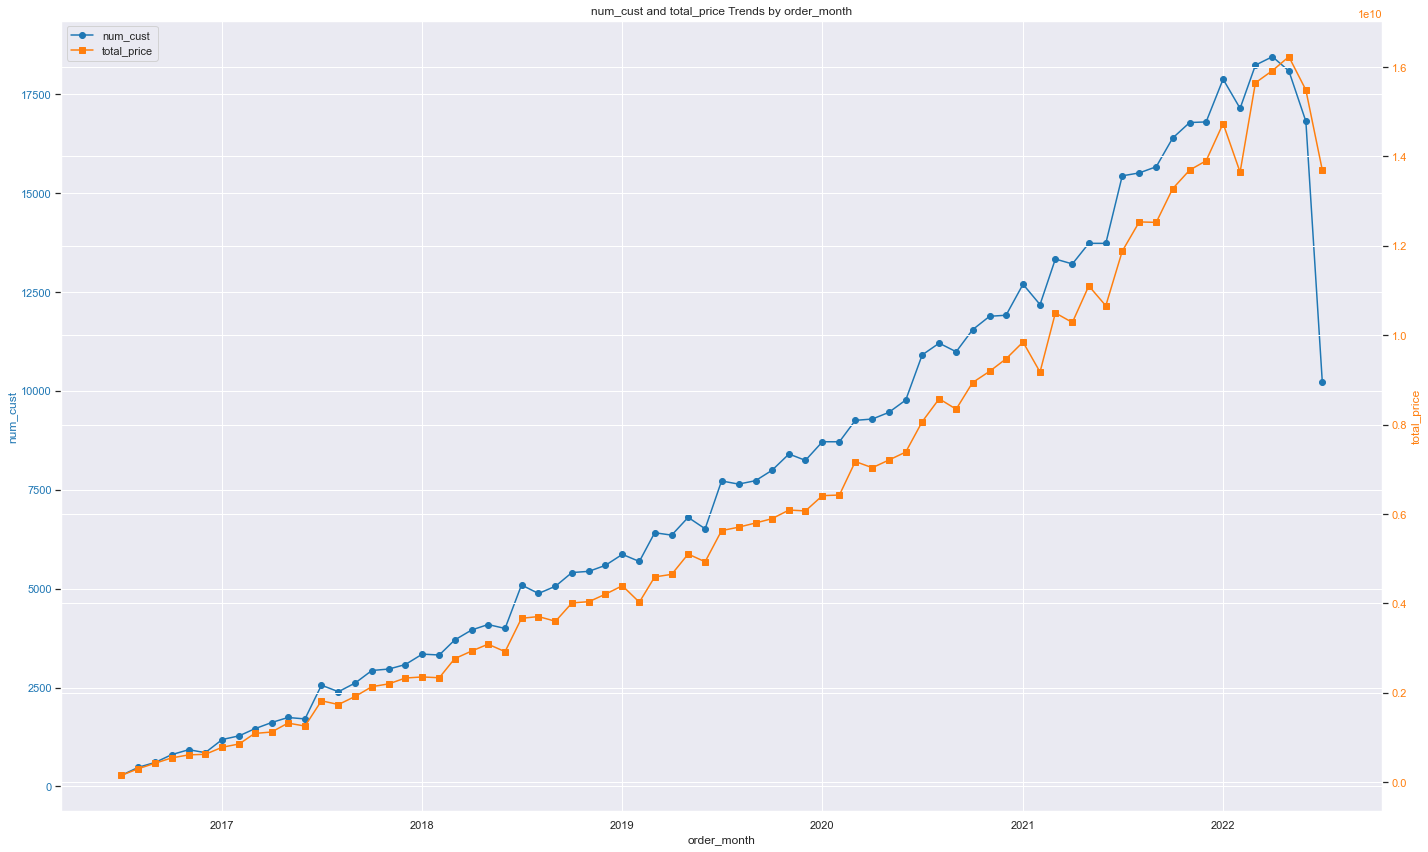

In [ ]:
plot_trends(df_spc, 'order_month', 'num_cust', 'total_price')

#### 소결론: 고객수가 확실한 매출액 하락에 영향을 주고 있다. 다른 변수들은 뚜렷한 영향이 보이고 있지 않음.

#### 이슈트리 활용
매출액 = 주문건당 단가 x 주문 수 <br>
매출액 = 주문건당 단가 x (고객당 구매빈도 x 고객 수) <br>
매출액 = (구매품목당 단가 x 주문건당 구매품목수) x (고객당 구매빈도 x 고객 수) <br>

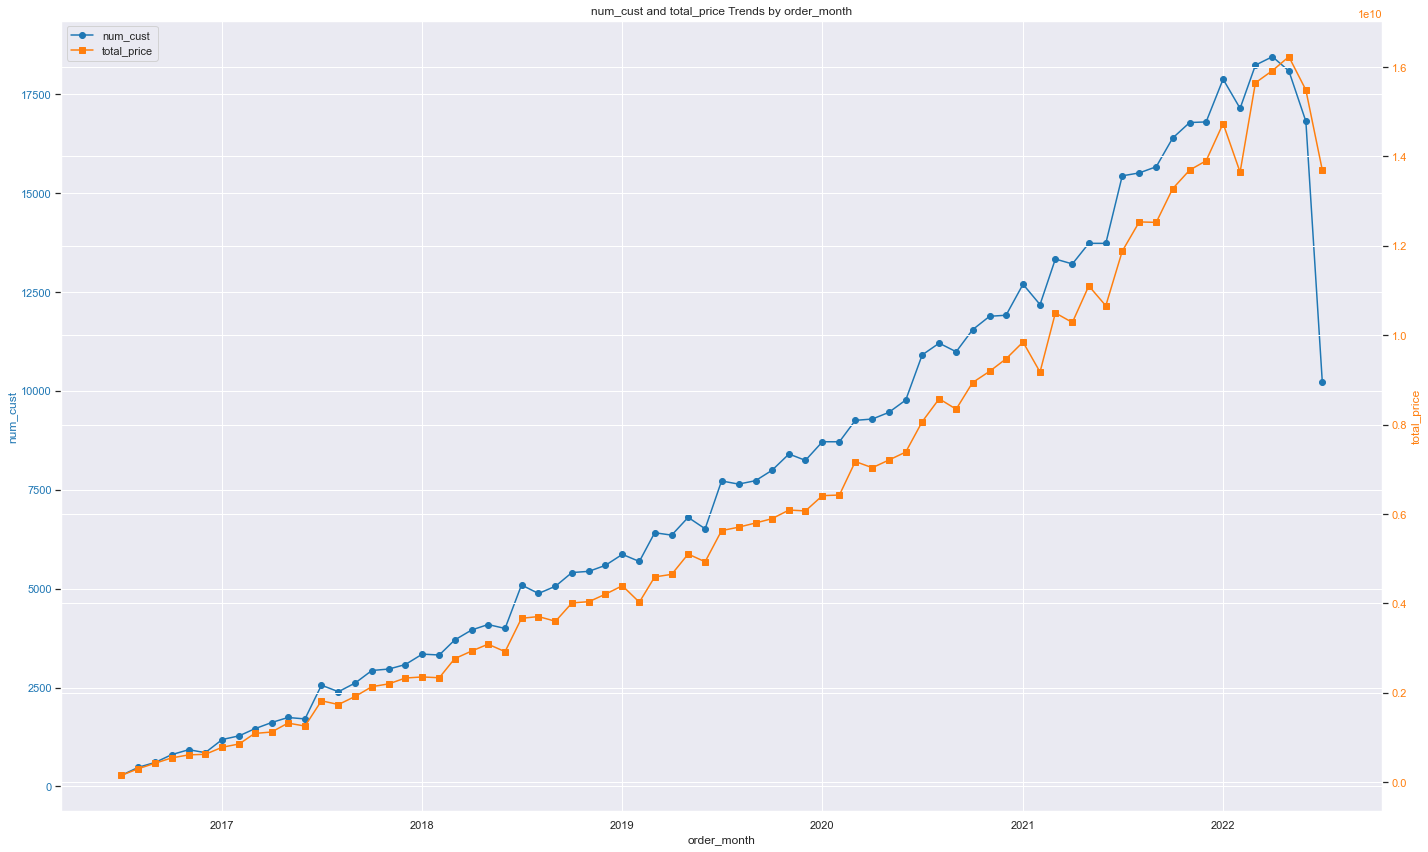

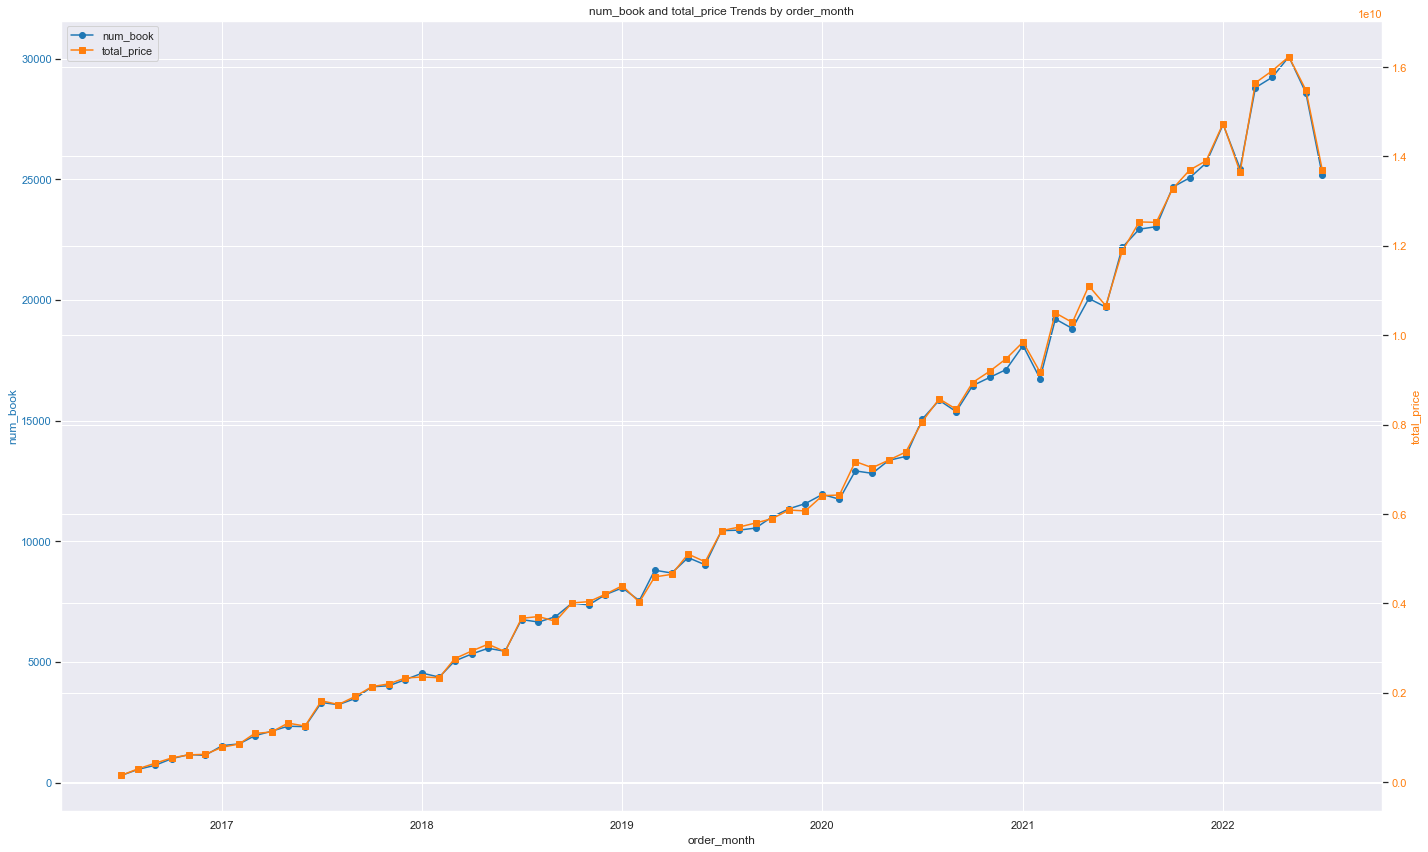

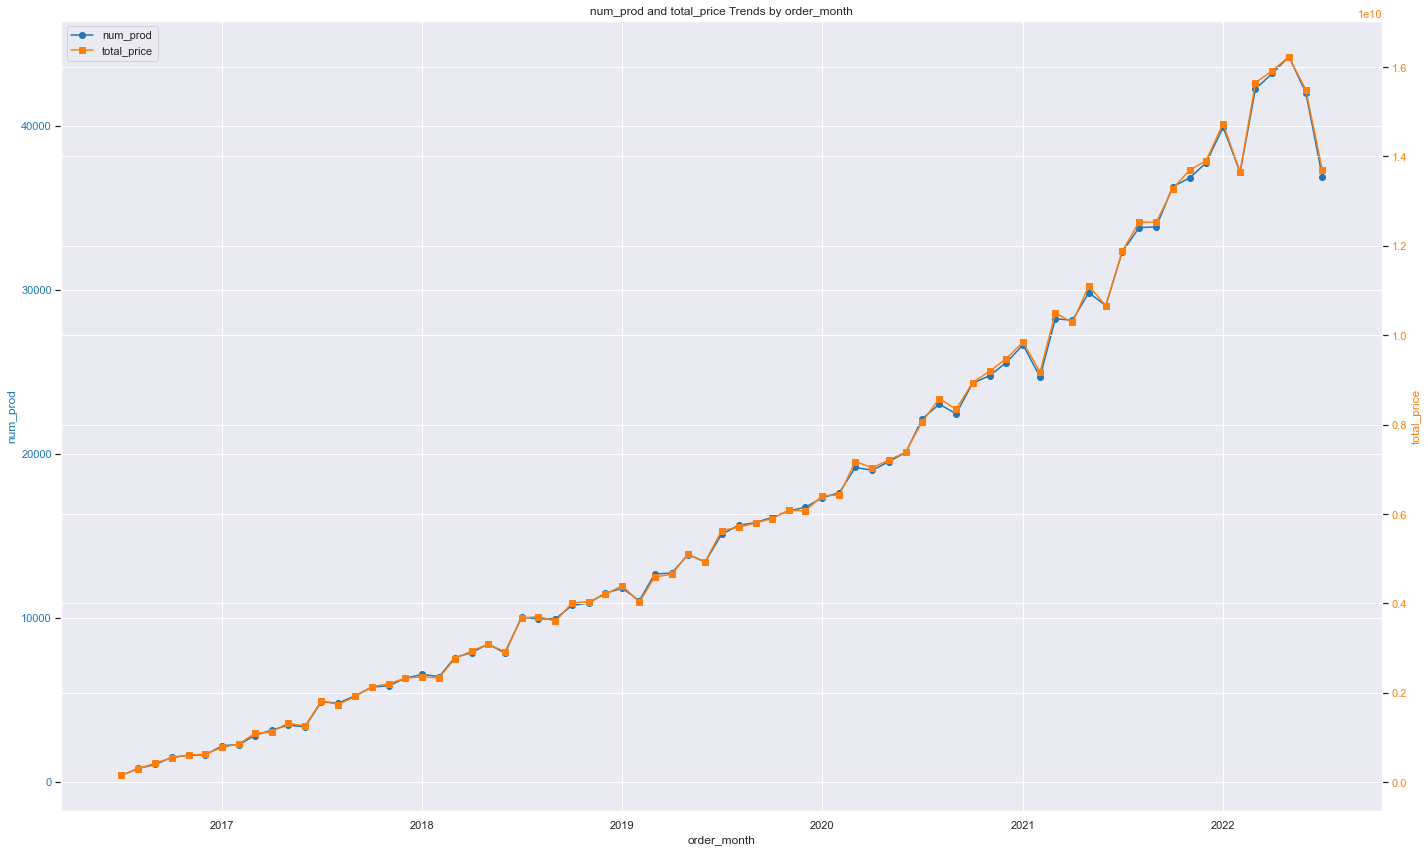

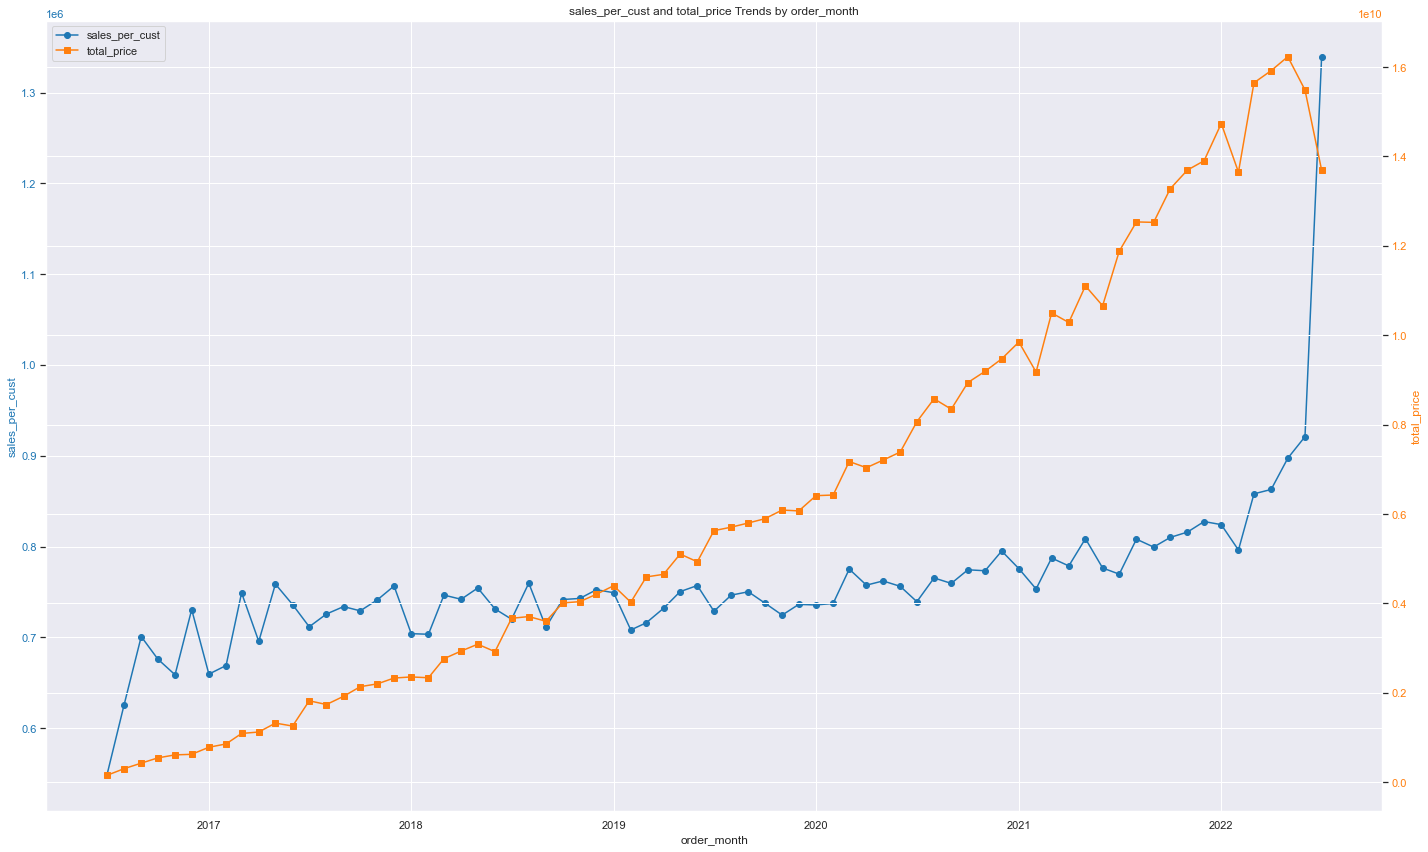

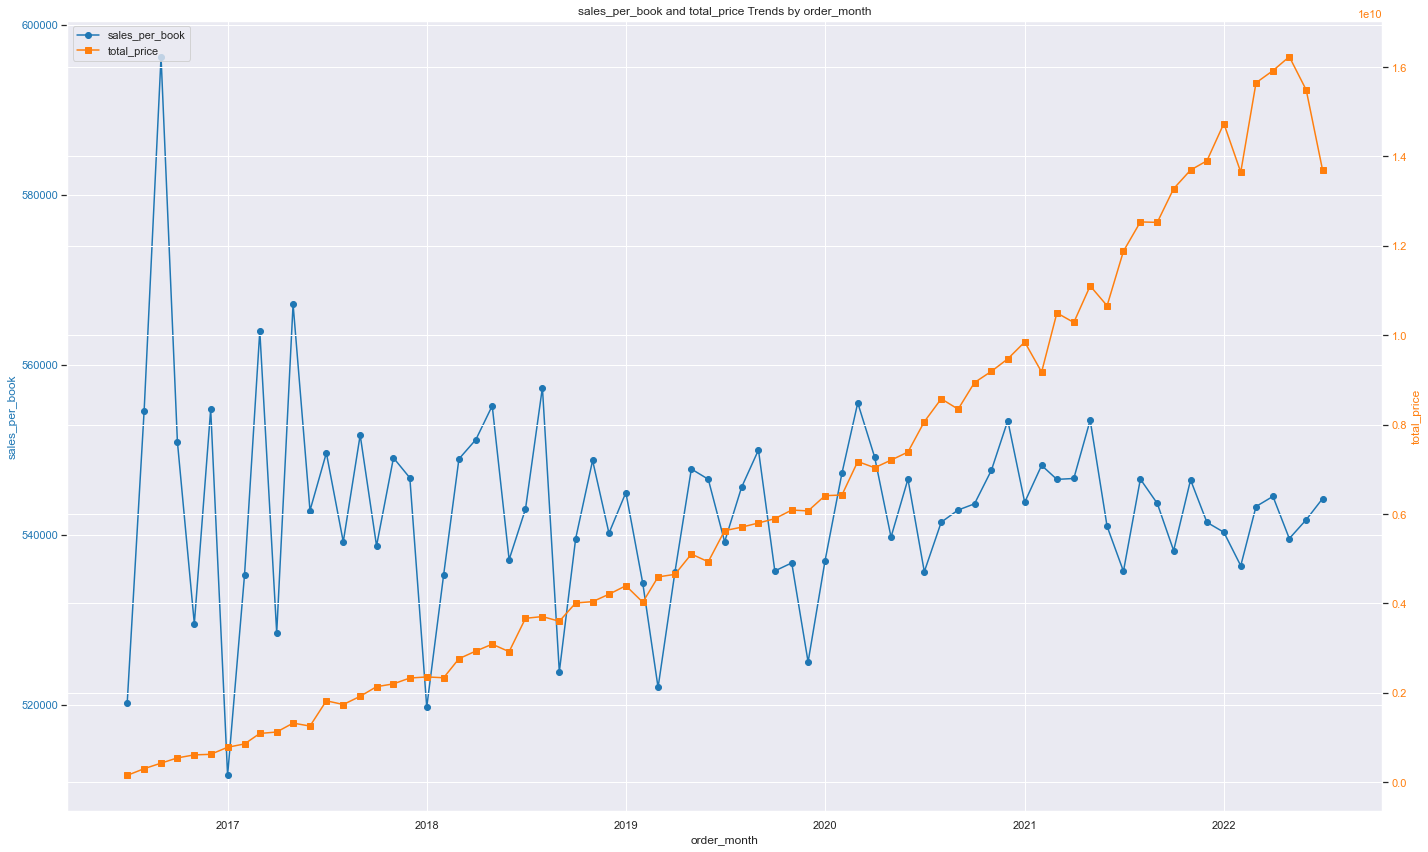

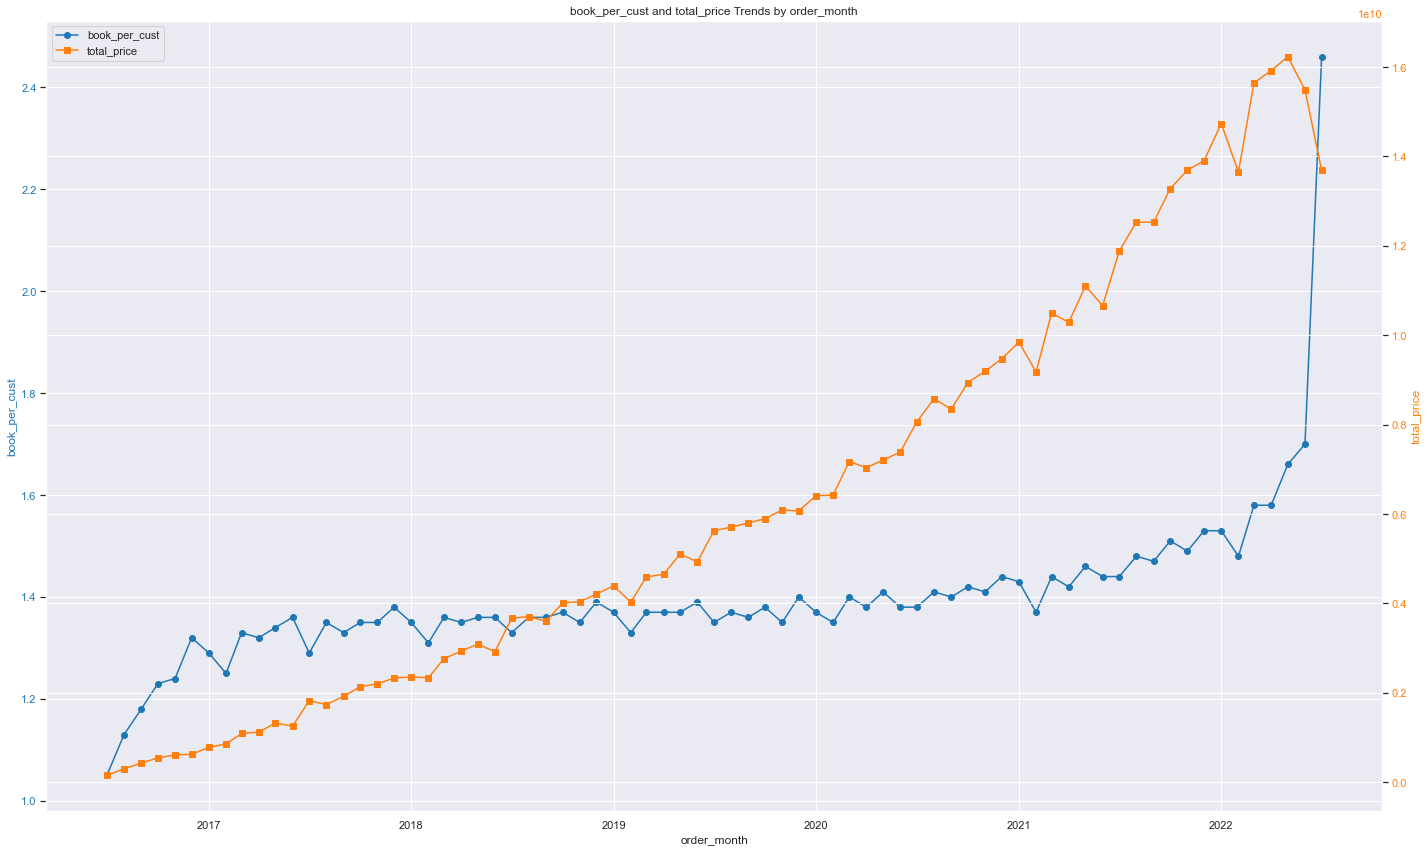

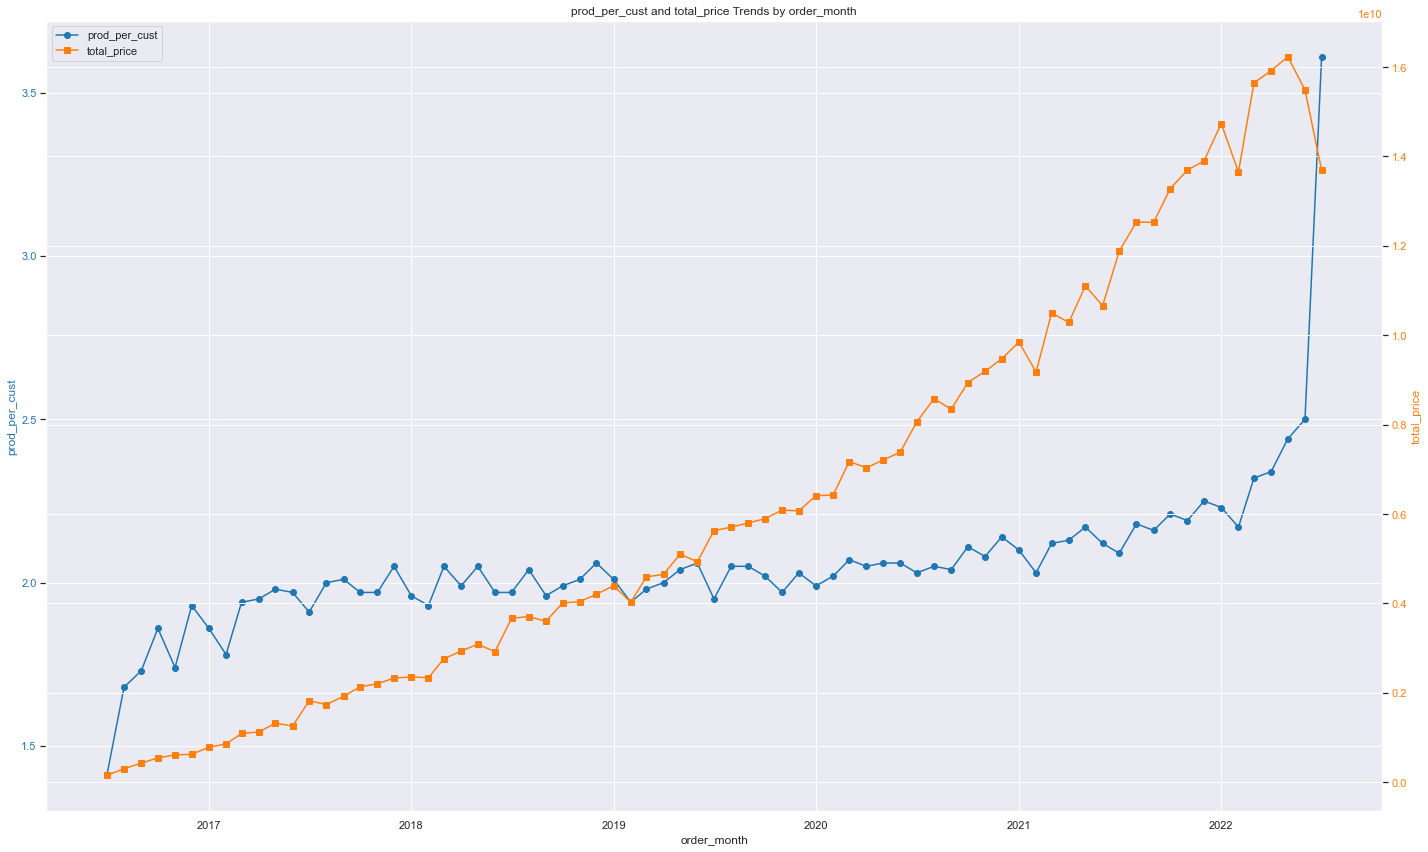

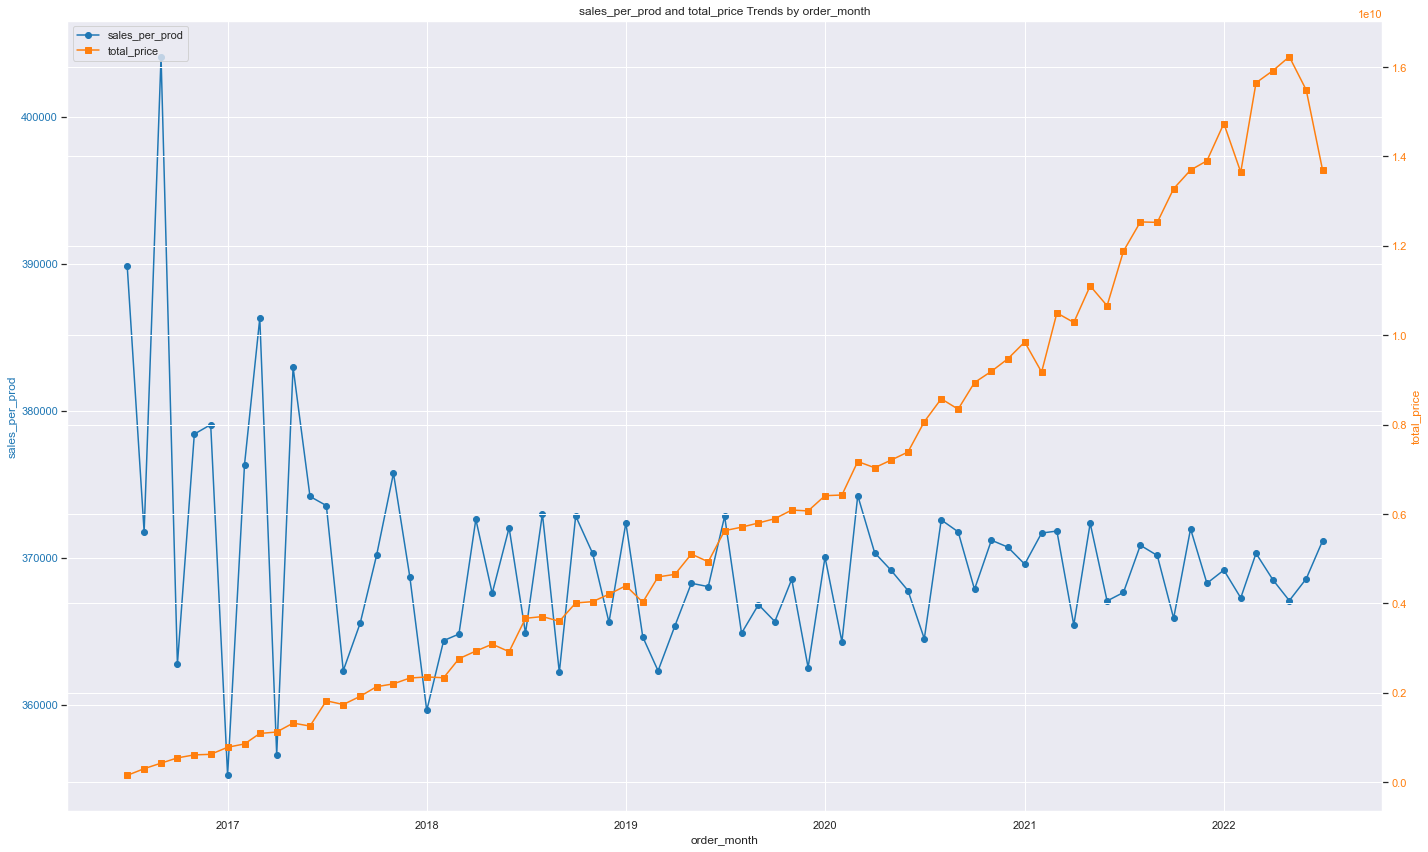

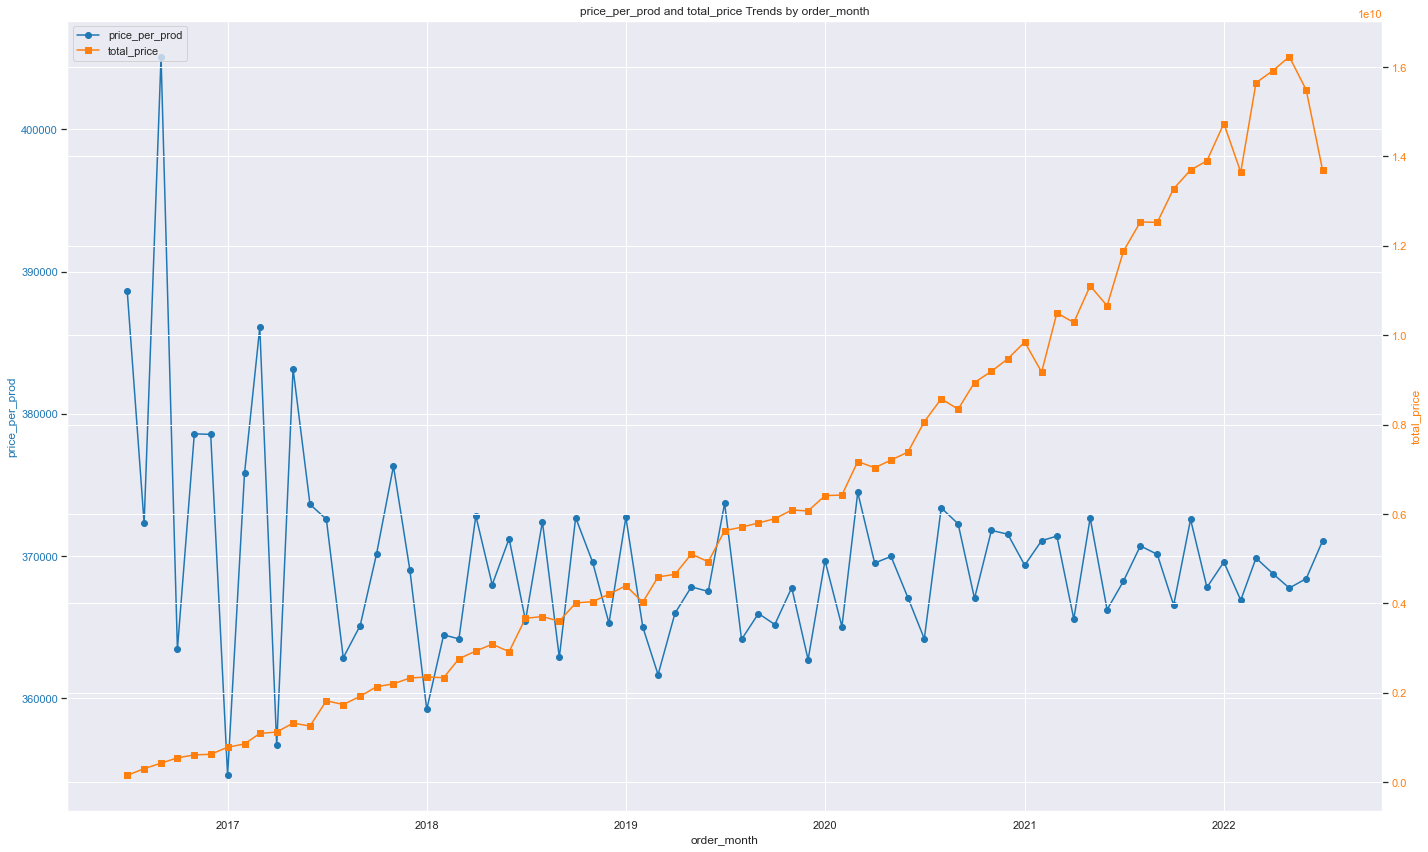

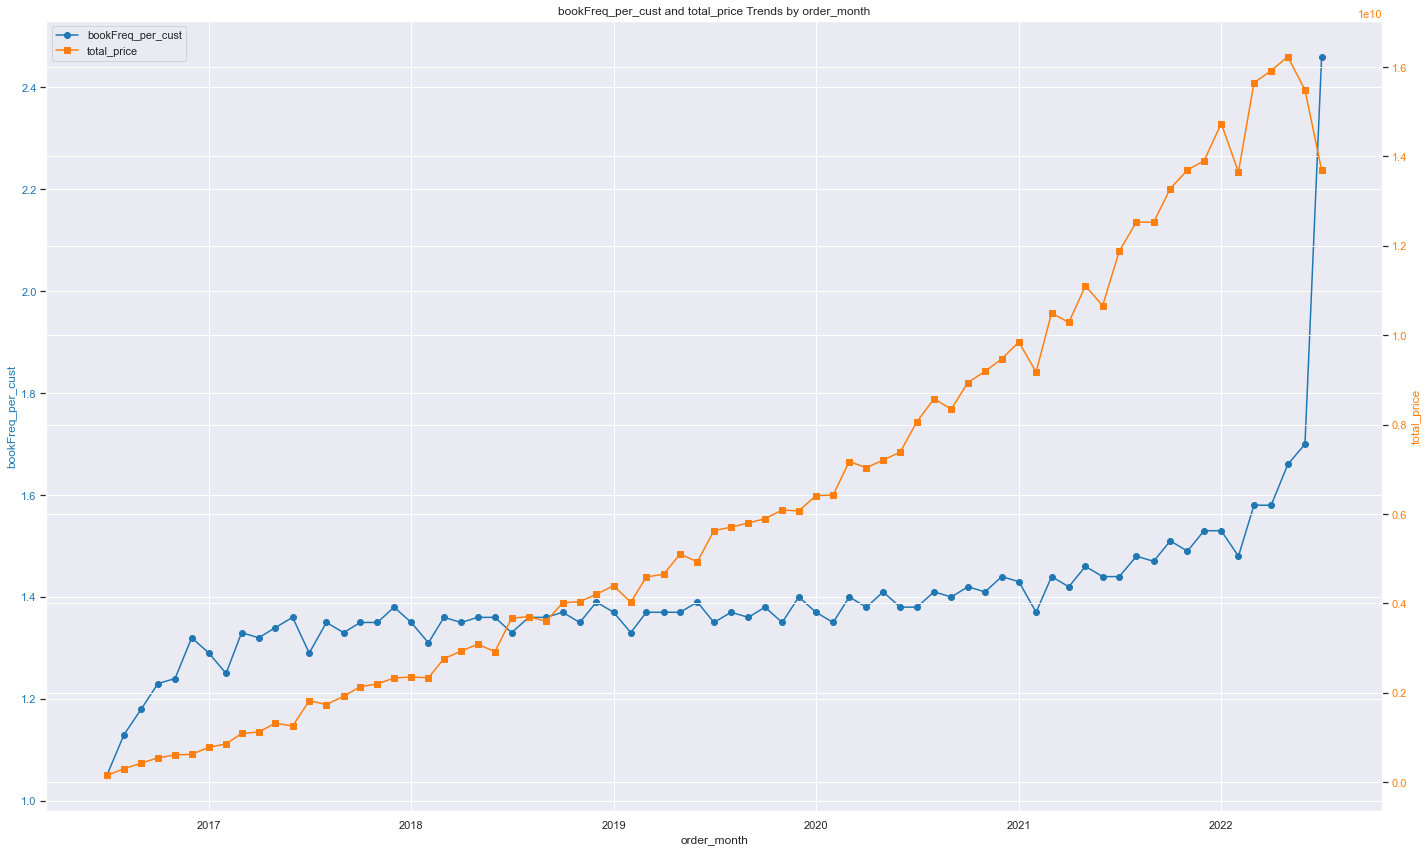

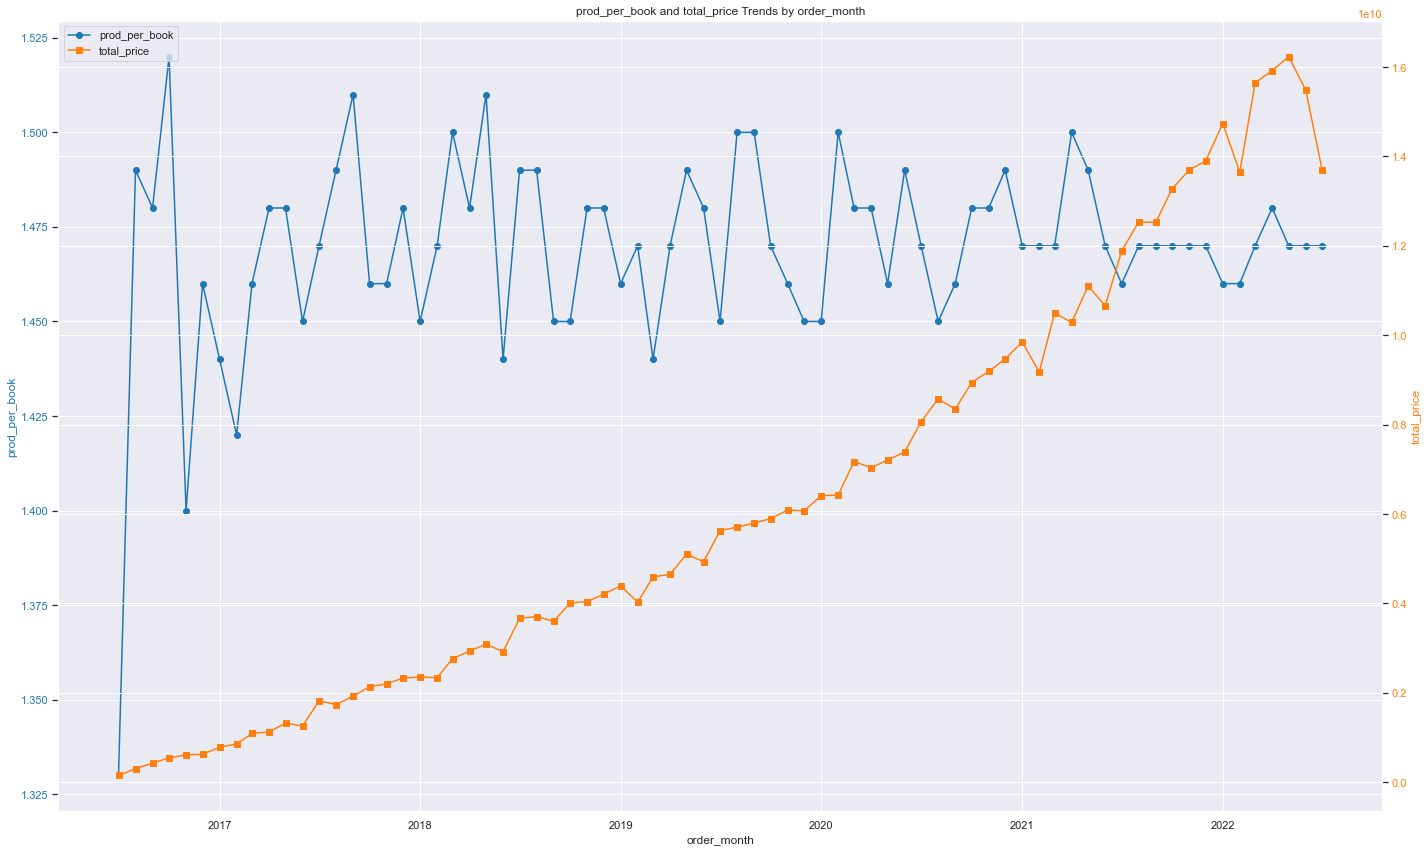

In [ ]:
for var in ['num_cust', 'num_book', 'num_prod', 'sales_per_cust', 'sales_per_book', 'book_per_cust', 'prod_per_cust', 'sales_per_prod', 'price_per_prod', 'bookFreq_per_cust', 'prod_per_book']:
    plot_trends(df_spc, 'order_month', var, 'total_price')